# **HOMEWORK 2 - STEAM REVIEWS 2021**
Simone Boesso / Davide Cacciatore / Carolina Romani

# ***Research Questions***

## **Introduction**

In [1]:
# Import some useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from scipy.stats import ttest_ind, levene, spearmanr

# To show numeric values and plots in a clear format
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings("ignore")

# Set styles for the plots
sns.set_style('darkgrid')
sns.set_context('talk')

### Import dataset on Google Colab

We need to import the dataset on Google Colab, so we install the package *kaggle*. 

We use '!' to give commands directly to the terminal.

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files

We upload the file *kaggle.json*. It's an API token generated by Kaggle, it allows us to access the datasets' list.

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"davidecacciatore","key":"2bc9c91c7b4b0ba356caaa0b3f5151a9"}'}

We create the *~/.kaggle* directory.

In [5]:
!mkdir ~/.kaggle

We move the *kaggle.json* file into the directory.

In [6]:
!cp kaggle.json ~/.kaggle/

We change the permission required to use the directory.

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

Finally, we download the dataset *steam-reviews-2021* directly from Kaggle.

In [8]:
!kaggle datasets download -d najzeko/steam-reviews-2021

100% 2.97G/2.97G [00:46<00:00, 27.7MB/s]
100% 2.97G/2.97G [00:46<00:00, 68.6MB/s]


In [9]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  steam-reviews-2021.zip
  inflating: steam_reviews.csv       


Now, we're ready to analyse the dataset.

### Chunking technique

Since the dataset is too large, we decided to divide it into chunks.

This technique allows to keep in memory smaller subset of data and therefore to analyse the entire dataset. The size of our desired chunk is specified using the *pd.read_csv method*. After the phase of preprocessing on each chunk, we concatenate it to create the final dataset where we do the analysis.

The preprocessing phase consists in converting the types of each column to types that are smaller in dimension, and to select a subset of columns. This preprocesssing has the goal to make all the analysis efficiently.

In [10]:
# Given the huge dimension of the dataset, we analyse it in chunks doing preprocessing
def chunking():
    chunk_iterator = pd.read_csv('steam_reviews.csv', chunksize = 100000, 
                                 parse_dates = ['timestamp_created', 'timestamp_updated', 'author.last_played'], 
                                 date_parser = dateparse)
    chunk_list = []  
    for chunk in chunk_iterator:  
        output = filtered_chunk(chunk)
        chunk_list.append(output)
    preprocessed_data = pd.concat(chunk_list)
    return preprocessed_data

## **[RQ1]** 

#### *After collecting information, the Data Scientists have to know what dataset they are dealing with, so let's start with an Exploratory Data Analysis (EDA). What can you say about our dataset? Please summarize its main characteristics with visual and tabular methods.*

In [11]:
#it checks if two rows are identical
def DuplicateRows(data):
    return data.duplicated(keep='first') 
    
#it checks if an author has written 2 reviews for the same app
def DuplicateReview_Author(data):    
    return data.duplicated(subset = ['app_id', 'author.steamid']) 

# it returns names' columns
def columns_names(data):
    return data.columns

# it returns 5 first rows
def First5Rows(data):
    return data.head()

# it returns infos about the types
def TypesColumns(data):
    return data.info()

# it returns some stats about numeric type fields
def Stats_Numeric_field(data):
    return data[['votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count', 'author.num_games_owned', 
                 'author.num_reviews', 'author.playtime_forever', 'author.playtime_last_two_weeks', 
                 'author.playtime_at_review']].describe()

In [12]:
# It parses the timestamps, returning a datetime format
def dateparse(timestamp):
    return pd.to_datetime(timestamp,unit="s")

In [13]:
# Loading the first 1000 rows of the dataset, to get basics information about it.
steam_dataset = pd.read_csv('steam_reviews.csv', nrows = 1000, 
                            parse_dates = ['timestamp_created', 'timestamp_updated', 'author.last_played'], 
                            date_parser = dateparse)

In [14]:
# To get columns' types
TypesColumns(steam_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Unnamed: 0                      1000 non-null   int64         
 1   app_id                          1000 non-null   int64         
 2   app_name                        1000 non-null   object        
 3   review_id                       1000 non-null   int64         
 4   language                        1000 non-null   object        
 5   review                          995 non-null    object        
 6   timestamp_created               1000 non-null   datetime64[ns]
 7   timestamp_updated               1000 non-null   datetime64[ns]
 8   recommended                     1000 non-null   bool          
 9   votes_helpful                   1000 non-null   int64         
 10  votes_funny                     1000 non-null   int64         
 11  weigh

In this dataset we have:
- **8 integer** columns: app_id, review_id, votes_helpful, votes_funny, comment_count, author.steamid, author.num_games_owned, author.num_reviews
- **3 string** columns: app_name, language, review
- **3 datetime** columns: timestamp_created, timestamp_updated, author.last_played
- **4 boolean** columns: recommended, steam_purchase, received_for_free, written_during_early_access
- **4 float** columns: weighted_vote_score, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played

In [15]:
# It returns a DataFrame reducing the data to the numeric columns
def filtered_chunk(data):
    
    # We set the column type in order to reduce their dimension
    # They're all 'int32' or 'float32' except 'app_id' and 'author.steamid' that are numbers bigger than 32 bits,
    # so we set 'int64'.
    types_diz = {'app_id':'int64', 'author.steamid':'int64',
                 'votes_helpful':'int32', 'votes_funny':'int32',
                 'weighted_vote_score':'float32', 'comment_count':'int32',
                 'author.num_games_owned':'int32', 'author.num_reviews':'int32'
                }
    
    # Subset the columns we need from our dataset 
    columns = ['app_id', 'author.steamid',
               'votes_helpful','votes_funny',
               'weighted_vote_score','comment_count', 
               'author.num_games_owned','author.num_reviews',
               'author.playtime_forever', 'author.playtime_last_two_weeks',
               'author.playtime_at_review'
              ]
    
    # We decided to delete all the rows with at least one NA value, instead of assign a default value
    # We subset the column, drop the NA and finally convert the types
    db = data[columns].dropna(subset=columns).astype(types_diz)
    return db

In [16]:
# We start creating the preprocessed data 
preprocessed_data = chunking()

Now, we can do some analysis on the preprocessed data.

In [17]:
print("The dataset has", len(preprocessed_data["app_id"]), 'rows.')

The dataset has 21721687 rows.


In [18]:
# To get the columns names.
columns_names(preprocessed_data)

Index(['app_id', 'author.steamid', 'votes_helpful', 'votes_funny',
       'weighted_vote_score', 'comment_count', 'author.num_games_owned',
       'author.num_reviews', 'author.playtime_forever',
       'author.playtime_last_two_weeks', 'author.playtime_at_review'],
      dtype='object')

In [19]:
# To check if there are duplicate rows
DuplicateRows(preprocessed_data)

0           False
1           False
2           False
3           False
4           False
            ...  
21747366    False
21747367    False
21747368    False
21747369    False
21747370    False
Length: 21721687, dtype: bool

We checked that in the dataset there are not duplicate rows.

In [20]:
# To check if an author can write 2 reviews for a game
DuplicateReview_Author(preprocessed_data)

0           False
1           False
2           False
3           False
4           False
            ...  
21747366    False
21747367    False
21747368    False
21747369    False
21747370    False
Length: 21721687, dtype: bool

We checked that in the dataset each author can write only one review for each application.

In [21]:
# To get columns' types
TypesColumns(preprocessed_data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21721687 entries, 0 to 21747370
Data columns (total 11 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   app_id                          int64  
 1   author.steamid                  int64  
 2   votes_helpful                   int32  
 3   votes_funny                     int32  
 4   weighted_vote_score             float32
 5   comment_count                   int32  
 6   author.num_games_owned          int32  
 7   author.num_reviews              int32  
 8   author.playtime_forever         float64
 9   author.playtime_last_two_weeks  float64
 10  author.playtime_at_review       float64
dtypes: float32(1), float64(3), int32(5), int64(2)
memory usage: 1.5 GB


In [22]:
# Plot the first 5 rows
First5Rows(preprocessed_data)

,app_id,author.steamid,votes_helpful,votes_funny,weighted_vote_score,comment_count,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review
0,292030,76561199095369542,0,0,0.00,0,6,2,"1,909.00","1,448.00","1,909.00"
1,292030,76561198949504115,0,0,0.00,0,30,10,"2,764.00","2,743.00","2,674.00"
2,292030,76561199090098988,0,0,0.00,0,5,1,"1,061.00","1,061.00","1,060.00"
3,292030,76561199054755373,0,0,0.00,0,5,3,"5,587.00","3,200.00","5,524.00"
4,292030,76561199028326951,0,0,0.00,0,7,4,217.00,42.00,217.00


In [23]:
# To get stats from numeric field
Stats_Numeric_field(preprocessed_data)

,votes_helpful,votes_funny,weighted_vote_score,comment_count,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review
count,"21,721,687.00","21,721,687.00","21,721,687.00","21,721,687.00","21,721,687.00","21,721,687.00","21,721,687.00","21,721,687.00","21,721,687.00"
mean,1.90,0.81,0.16,0.13,132.65,10.51,"16,103.97",155.69,"8,807.42"
std,39.85,27.90,0.22,2.20,281.45,34.21,"37,439.43",730.29,"23,885.53"
min,0.00,-15.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
25%,0.00,0.00,0.00,0.00,22.00,2.00,"1,253.00",0.00,559.00
50%,0.00,0.00,0.00,0.00,61.00,4.00,"4,314.00",0.00,"1,881.00"
75%,1.00,0.00,0.48,0.00,145.00,10.00,"14,931.00",0.00,"6,823.00"
max,"29,608.00","22,532.00",1.00,"4,893.00","24,258.00","5,236.00","3,744,943.00","27,039.00","3,228,103.00"


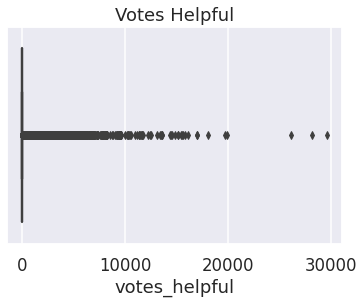

In [24]:
# Plot the boxplots of the variables
# Votes Helpful
sns.boxplot(x = 'votes_helpful', data = preprocessed_data).set_title('Votes Helpful')
plt.show()

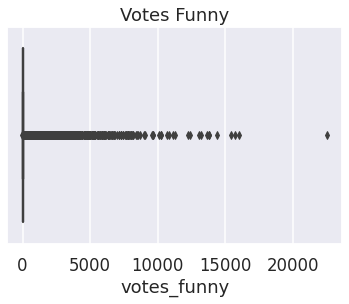

In [25]:
# Votes funny
sns.boxplot(x = 'votes_funny', data = preprocessed_data).set_title('Votes Funny')
plt.show()

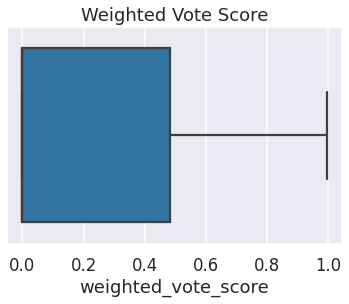

In [26]:
# Weighted Vote Score
sns.boxplot(x = 'weighted_vote_score', data = preprocessed_data).set_title('Weighted Vote Score')
plt.show()

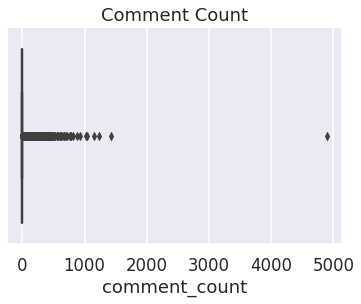

In [27]:
# Comment count
sns.boxplot(x = 'comment_count', data = preprocessed_data).set_title('Comment Count')
plt.show()

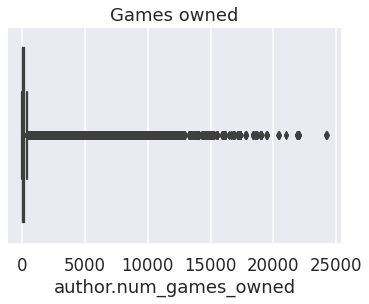

In [28]:
# Games owned
sns.boxplot(x = 'author.num_games_owned', data = preprocessed_data).set_title('Games owned')
plt.show()

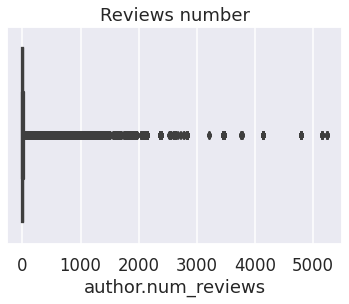

In [29]:
# Reviews number
sns.boxplot(x = 'author.num_reviews', data = preprocessed_data).set_title('Reviews number')
plt.show()

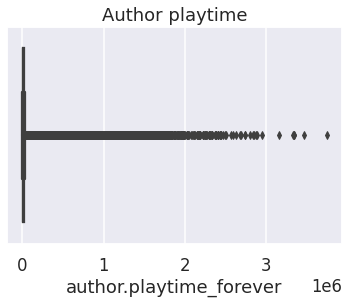

In [30]:
# Author playtime
sns.boxplot(x = 'author.playtime_forever', data = preprocessed_data).set_title('Author playtime')
plt.show()

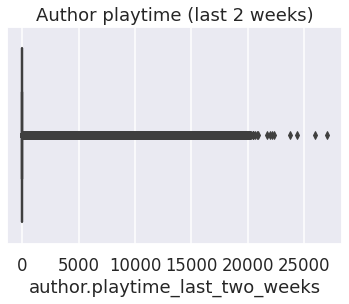

In [31]:
# Author playtime (last 2 weeks)
sns.boxplot(x = 'author.playtime_last_two_weeks', data = preprocessed_data).set_title('Author playtime (last 2 weeks)')
plt.show()

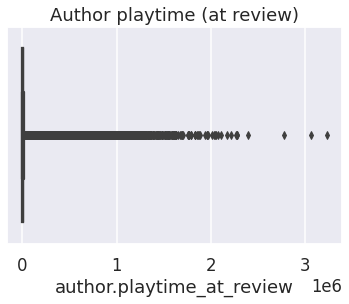

In [32]:
# Author playtime (at review)
sns.boxplot(x = 'author.playtime_at_review', data = preprocessed_data).set_title('Author playtime (at review)')
plt.show()

All these variables have strange distributions. There are a lot of very low values and then some outliers. That's why the boxplots are so crashed.

## **[RQ2]**

#### *Let's explore the dataset by finding simple insights into the reviews.*

In [33]:
def filtered_chunk(data):
    
    # We set the column type in order to reduce their dimension
    types_diz = {'app_id':'int64', 'author.steamid':'int64',
                 'weighted_vote_score':'float32', 
                }
    
    # Subset the columns we need from our dataset 
    columns = ['app_name', 'app_id', 'author.steamid','steam_purchase',
               'weighted_vote_score','recommended', 'received_for_free'
              ]
      
    # We decided to delete all the rows with at least one NA value, instead of assign a default value
    # We subset the column, drop the NA and finally convert the types
    db=data[columns].dropna(subset=columns)
    return db

In [34]:
preprocessed_data=chunking()

#### *Plot the number of reviews for each application in descending order.*

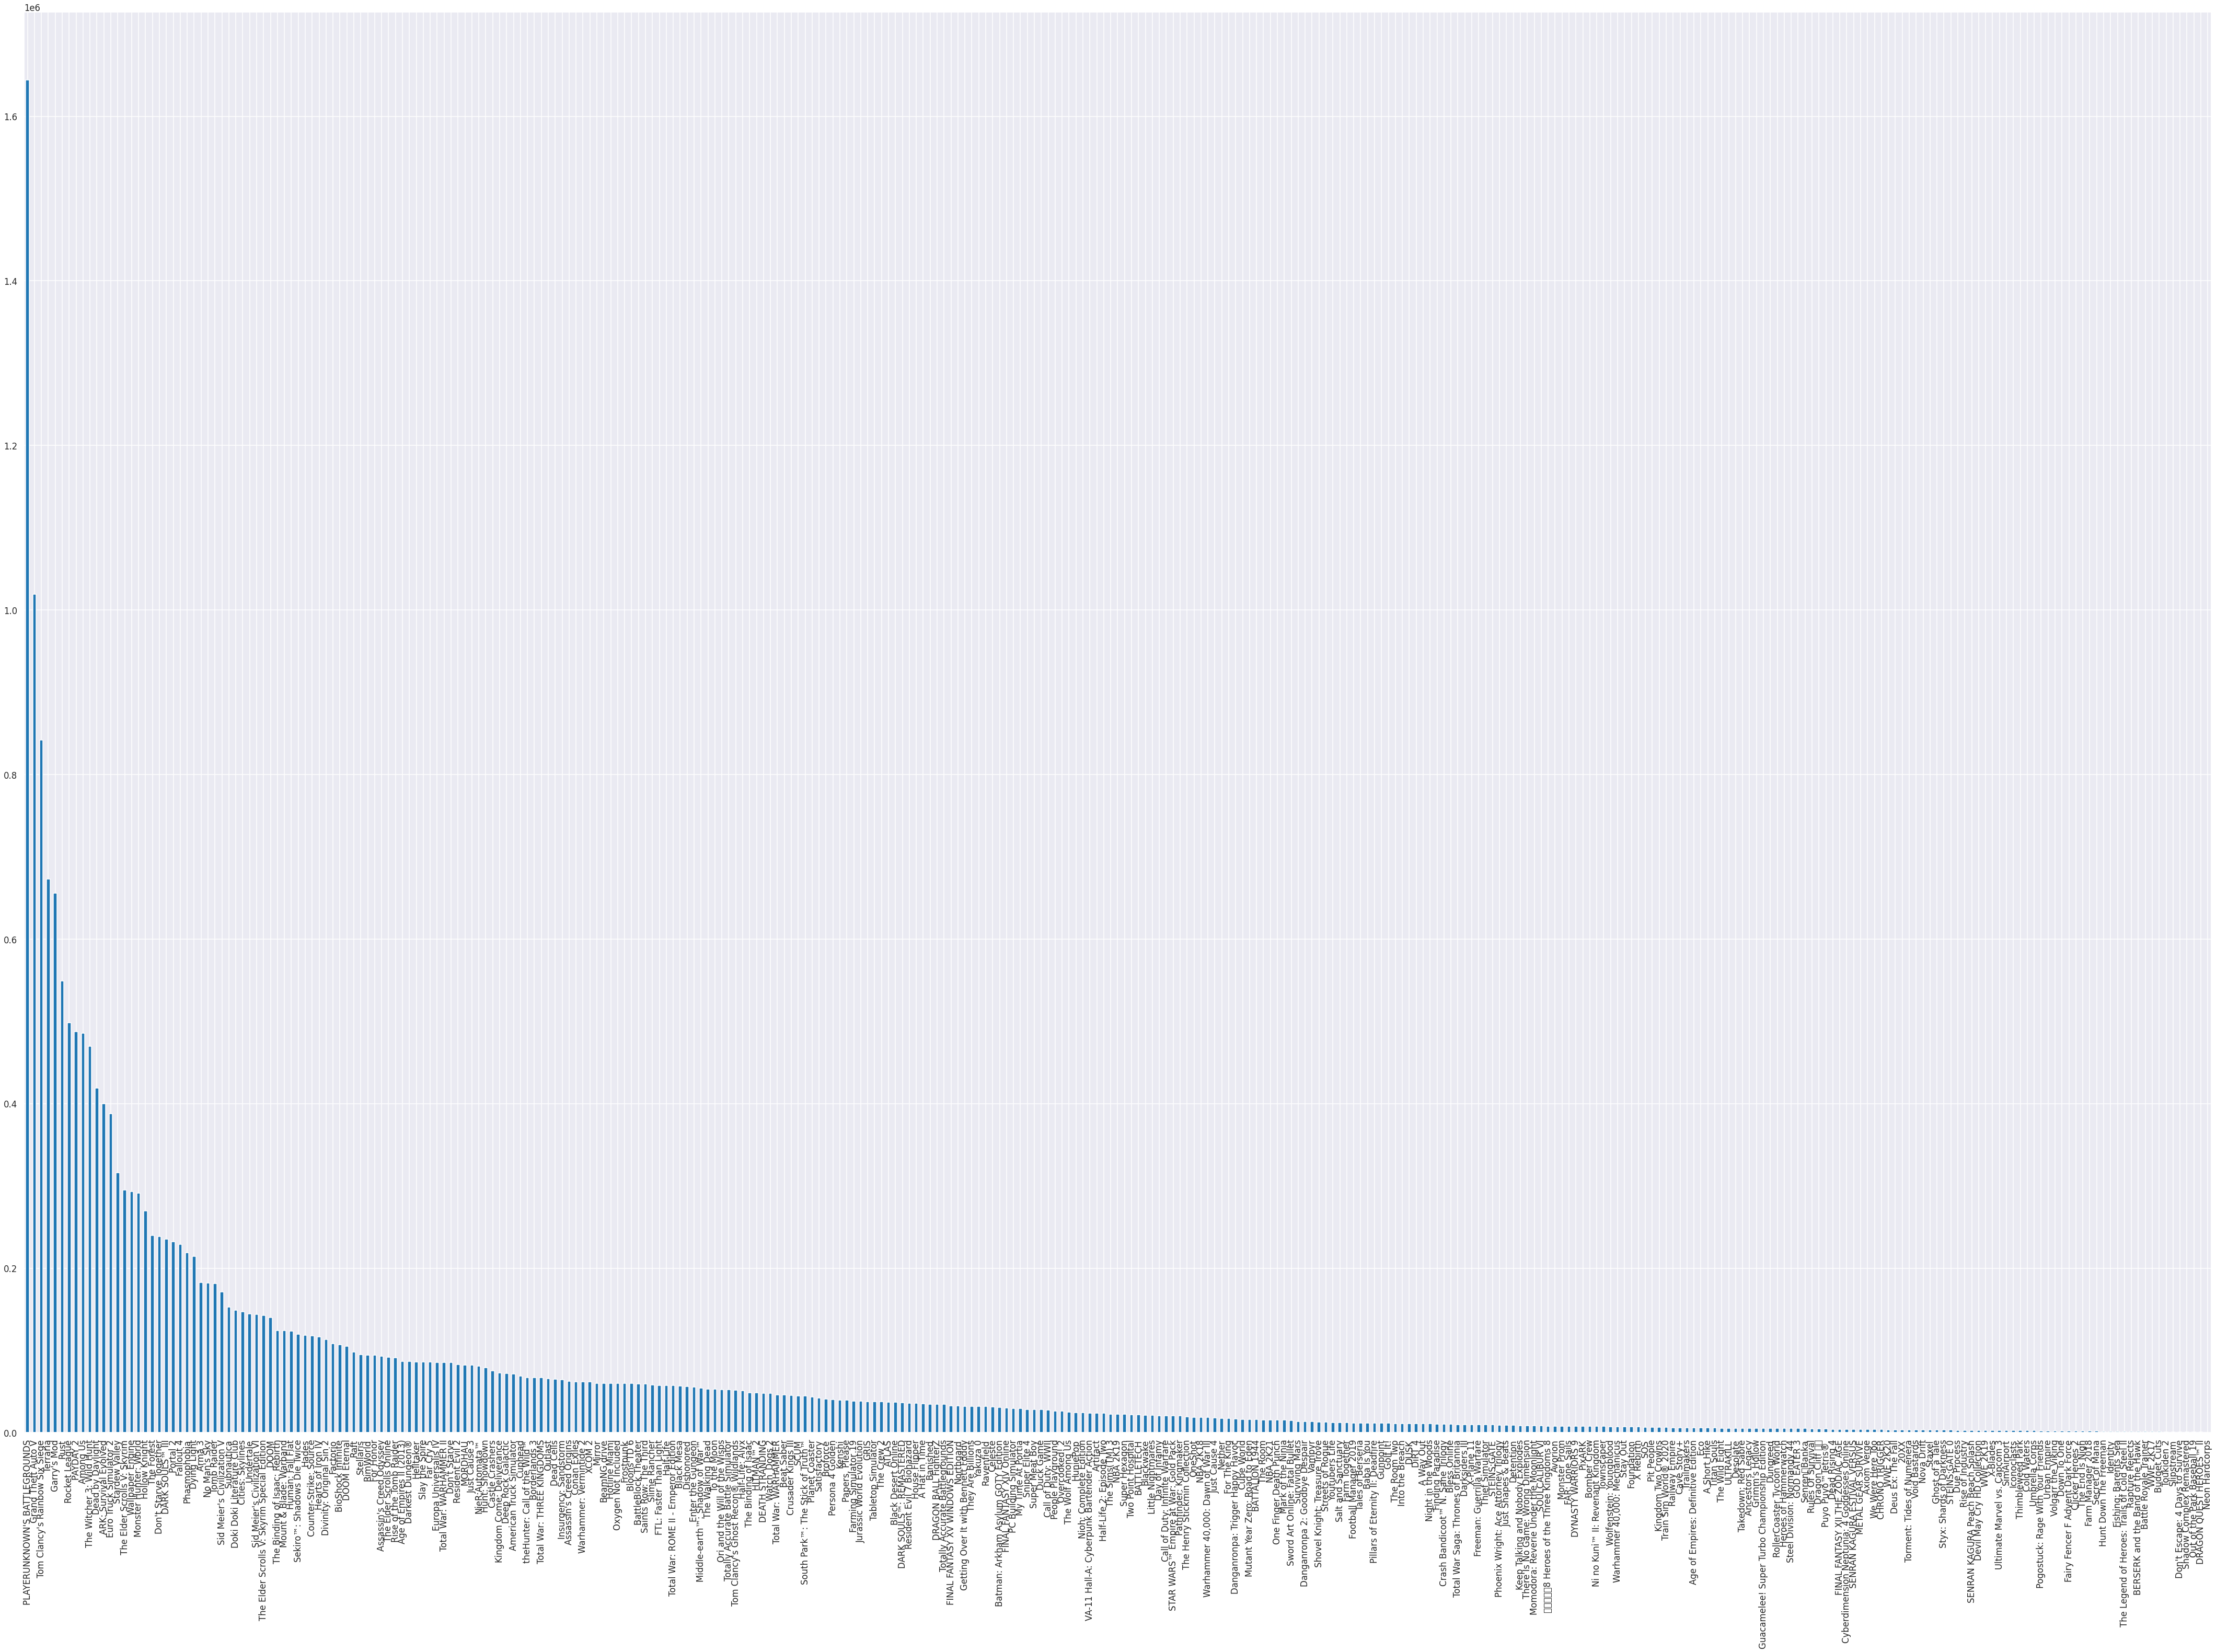

In [35]:
# It gets the number of review for each application (descending order) and plot it.
preprocessed_data['app_name'].value_counts().plot.bar(figsize = (75,50))

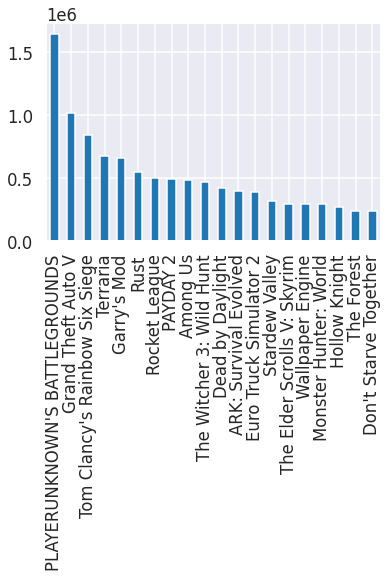

In [36]:
# Plot only the first 20 apps
preprocessed_data['app_name'].value_counts().head(20).plot.bar()

#### *What applications have the best Weighted Vote Score?*

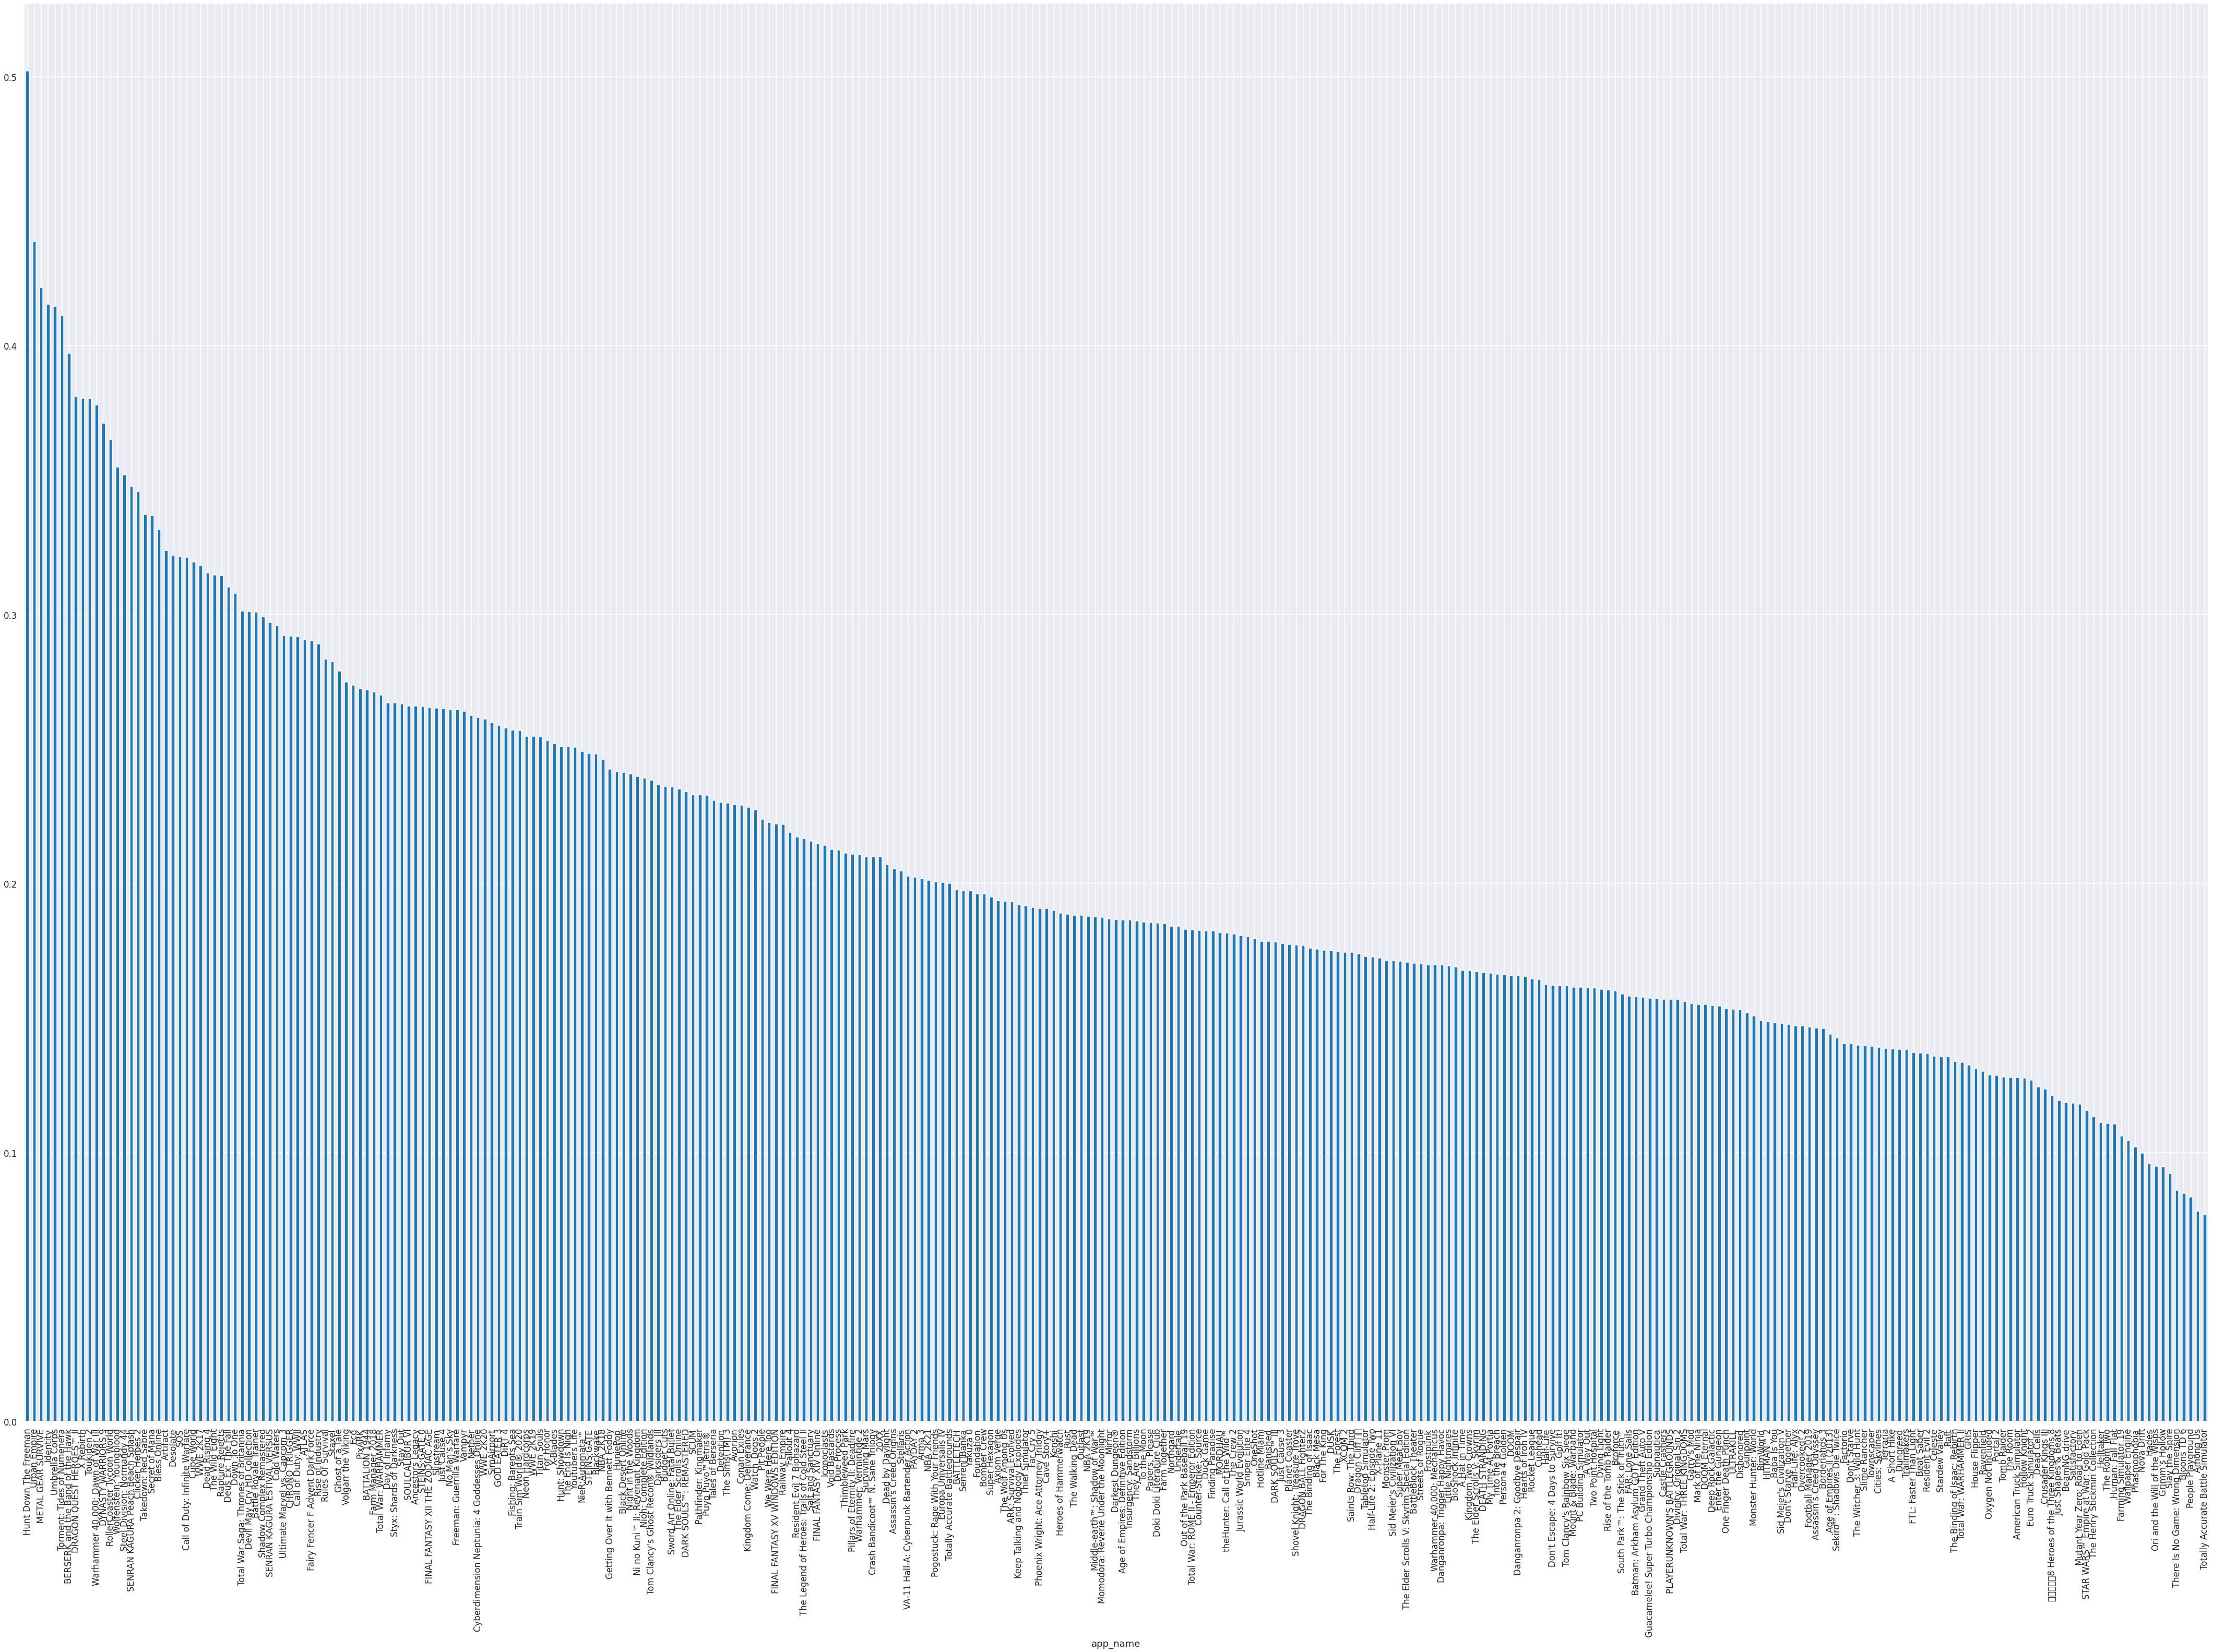

In [37]:
# It computes for each application the mean of the weighted scores and plot the graph.
Weighted_score_mean = preprocessed_data.groupby(["app_name"])['weighted_vote_score'].mean().sort_values(ascending=False)
Weighted_score_mean.plot.bar(figsize=(75,50))

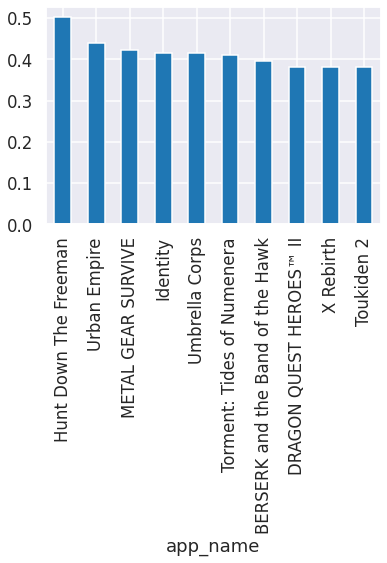

In [38]:
# Plot the top 10 application for the mean of the weighted scores.
Weighted_score_mean.head(10).plot.bar()

In [39]:
print('The top 10 apps with the best Weighted Vote Score are:\n', Weighted_score_mean.head(10))

The top 10 apps with the best Weighted Vote Score are:
 app_name
Hunt Down The Freeman              0.50
Urban Empire                       0.44
METAL GEAR SURVIVE                 0.42
Identity                           0.42
Umbrella Corps                     0.41
Torment: Tides of Numenera         0.41
BERSERK and the Band of the Hawk   0.40
DRAGON QUEST HEROES™ II            0.38
X Rebirth                          0.38
Toukiden 2                         0.38
Name: weighted_vote_score, dtype: float64


#### *Which applications have the most and the least recommendations?*

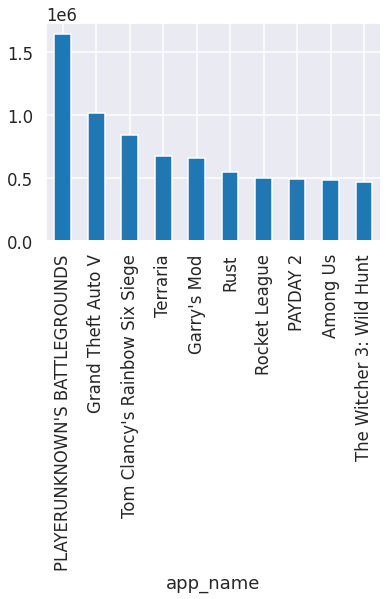

In [40]:
# it finds the number of reviews for each application where the user has recommended the app
Count_Recomended = preprocessed_data.groupby('app_name', 'recommended' == True)['recommended'].count()
# we plot it in ascending order the 10 most recommended
Count_Recomended.sort_values(ascending=False).iloc[0:10].plot.bar()

In [41]:
print('The top 10 apps with the most recommendations are:\n', Count_Recomended.sort_values(ascending=False).iloc[0:10])

The top 10 apps with the most recommendations are:
 app_name
PLAYERUNKNOWN'S BATTLEGROUNDS     1644255
Grand Theft Auto V                1019116
Tom Clancy's Rainbow Six Siege     841918
Terraria                           672815
Garry's Mod                        655524
Rust                               549074
Rocket League                      498565
PAYDAY 2                           487747
Among Us                           485293
The Witcher 3: Wild Hunt           469395
Name: recommended, dtype: int64


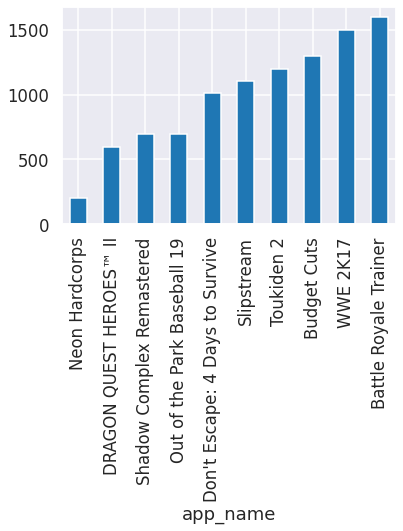

In [42]:
# it plots the 10 least recommended games
Count_Recomended.sort_values().iloc[:10].plot.bar()

In [43]:
print('The 10 apps with the least recommendations are:\n', Count_Recomended.sort_values().iloc[:10])

The 10 apps with the least recommendations are:
 app_name
Neon Hardcorps                      200
DRAGON QUEST HEROES™ II             600
Shadow Complex Remastered           700
Out of the Park Baseball 19         700
Don't Escape: 4 Days to Survive    1013
Slipstream                         1103
Toukiden 2                         1200
Budget Cuts                        1298
WWE 2K17                           1499
Battle Royale Trainer              1600
Name: recommended, dtype: int64


#### *How many of these applications were purchased, and how many were given for free?*

In [44]:
#It returns the number of not purchased and purchased game
def Purchased(data):
    return data['steam_purchase'].value_counts()

#It returns the number of games received for free
def Received_free(data):
    return data['received_for_free'].value_counts()
  
# It visualizes the number of purchased and not purchased game
def Print_Purchased(data):
    print("Purchased game: {}\nNot purchased game: {}".format(Purchased(data)[1],Purchased(data)[0]))

# It visualizes the number of "received for free" game (numbers of True)
def Print_receivedFree(data):
    print("Received for free:", Received_free(data)[1])

In [45]:
Print_Purchased(preprocessed_data)
Print_receivedFree(preprocessed_data)

Purchased game: 16842432
Not purchased game: 4904939
Received for free: 688061


We have $16,842,432$ purchased games and only $688,061$ received for free.

It means there are some reviews made for games neither purchased or received for free.

## **[RQ3]**

#### *Now it's important to understand the preferred time to do reviews.*

In [46]:
def filtered_chunk(data):
    
    # We set the column type in order to reduce their dimension
    types_diz = {'app_id':'int64', 'author.steamid':'int64', 'review_id':'int64'}
    
    # Subset the columns we need from our dataset
    columns = ['app_id', 'author.steamid', 'timestamp_created', 'review_id']

    # We decided to delete all the rows with at least one NA value, instead of assign a default value
    # We subset the column, drop the NA and finally convert the types
    db=data[columns].dropna(subset=columns).astype(types_diz)
    return db

In [47]:
preprocessed_data = chunking()

#### *What is the most common time that authors review an application? For example, authors usually write a review at 17:44.*

In [48]:
#It computes the number of reviews for each hour and minute 
def Num_Review(data):
    Data_frame=data.groupby([data.timestamp_created.dt.hour ,data.timestamp_created.dt.minute]).size()
    Data_frame=Data_frame.sort_values(ascending=False)
    return Data_frame

# It computes the index of max on given axis, default=0
def Max_count(serie):
    return serie.idxmax()

# It computes the index of the  maximum number of reviews given a dataframe 
def Print_max(data):
    frameNum = Num_Review(data)
    IndexMax = Max_count(frameNum)


timestamp_created  timestamp_created
14                 50                   19502
15                 5                    19370
14                 37                   19270
15                 7                    19248
                   4                    19237
                                        ...  
6                  7                    11748
5                  54                   11745
                   51                   11735
6                  20                   11671
                   2                    11670
Length: 1440, dtype: int64


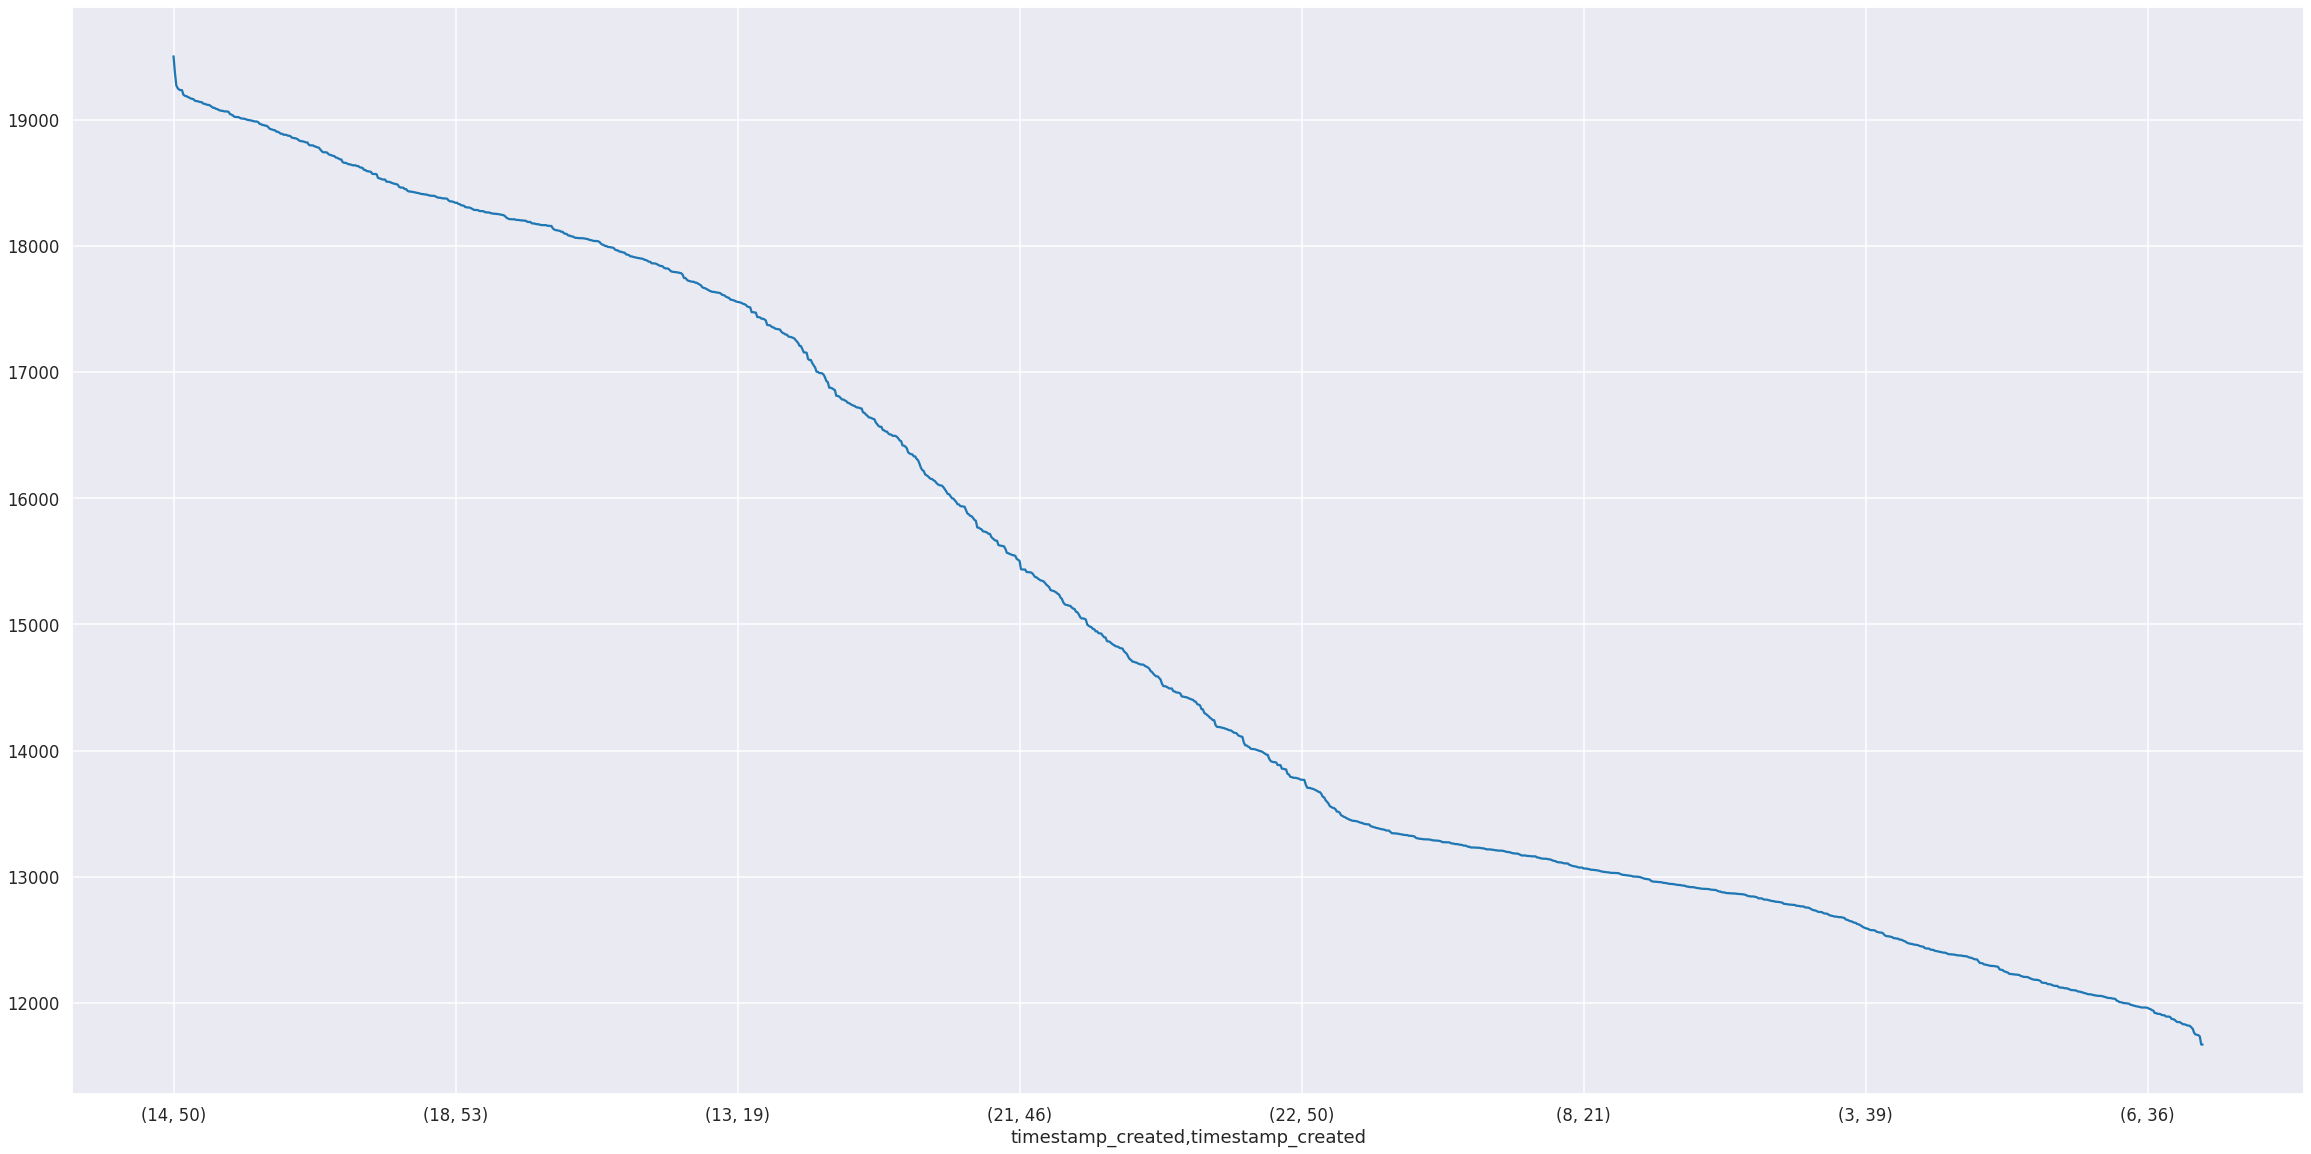

In [49]:
DataIndex = Num_Review(preprocessed_data)
DataIndex.plot.line(figsize=(40,20))
print(DataIndex)

In [50]:
massimo = Max_count(DataIndex)
print('The most common time that authors review an application is', massimo[0], ':', massimo[1])

The most common time that authors review an application is 14 : 50


#### *Create a function that receives as a parameter a list of time intervals and returns the plot the number of reviews for each of the intervals.*

In [51]:
#it plots the number of review for each interval
def Plot_intervals(data,intervals):
    df = preprocessed_data.set_index('timestamp_created')
    l=[]
    intervals2=[[pd.to_timedelta(i).seconds/3600,pd.to_timedelta(y).seconds/3600]for i,y in intervals]
    for s1,s2 in intervals2:
        numero = df[(df.index.hour >= s1) & (df.index.hour<=s2)].size
        l.append(numero)
    x = pd.Series(l,index=intervals)
    p = x.plot(figsize=(30,10))
    p.set_title('Reviews for each given interval')
    p.set_ylabel('Count (10 million)')

#### *Use the function that you created in the previous literal to plot the number of reviews between the following time intervals:*

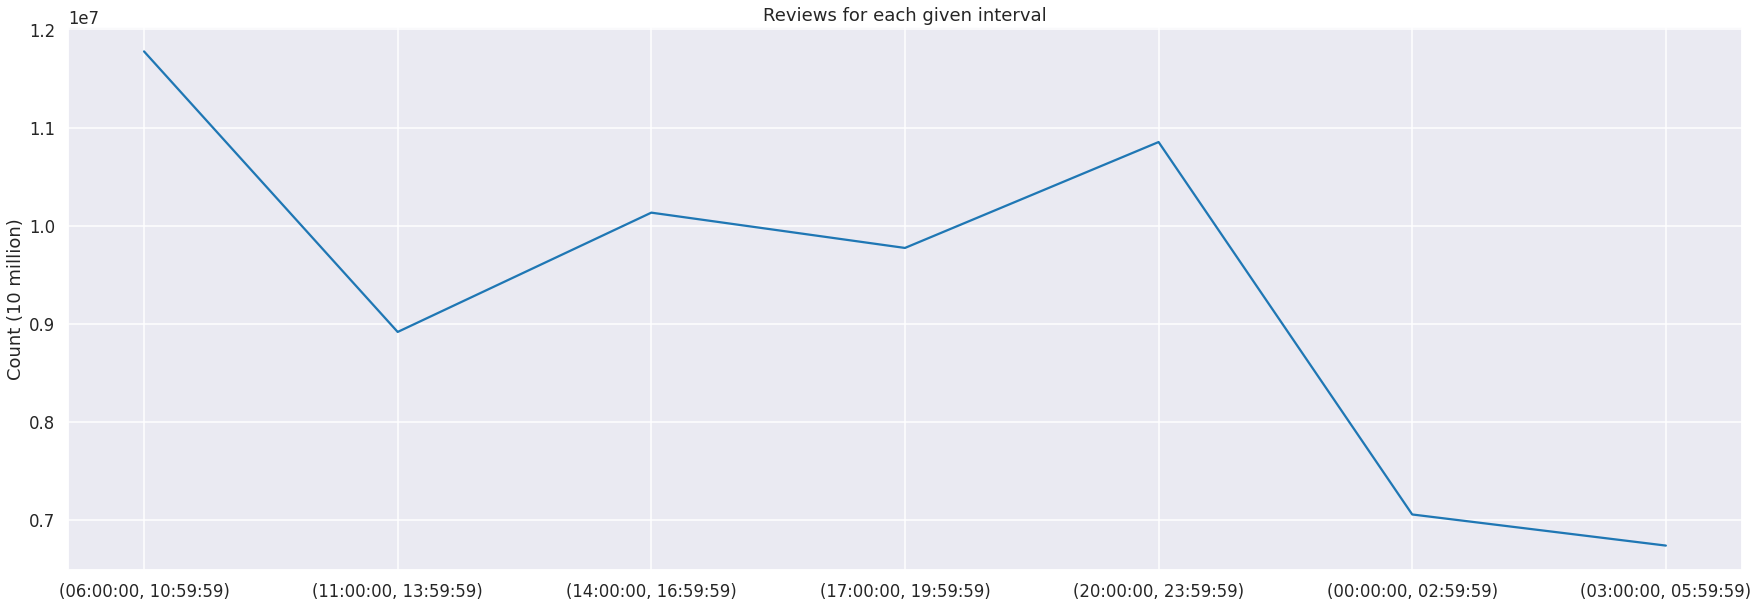

In [52]:
intervals = [("06:00:00","10:59:59"), ("11:00:00","13:59:59"), 
             ("14:00:00","16:59:59"), ("17:00:00","19:59:59"),
             ("20:00:00","23:59:59"), ("00:00:00","02:59:59"),
             ("03:00:00","05:59:59")]

Plot_intervals(preprocessed_data, intervals)

The time interval with the most reviews is from 6 am to 11 am.

The time interval with the less reviews is from 3 am to 6 am.

## **[RQ4]**

#### *As Steam is a worldwide platform, the reviews can be done in many languages. Let's extract some information about it.*

In [53]:
def filtered_chunk(data):
    
    # We set the column type in order to reduce their dimension
    types_diz = {'language':'str', 'votes_helpful':'int32', 'votes_funny':'int32'}
    
    # Subset the columns we need from our dataset 
    columns = ['language', 'votes_helpful', 'votes_funny']

    # We decided to delete all the rows with at least one NA value, instead of assign a default value
    # We subset the column, drop the NA and finally convert the types
    db = data[columns].dropna(subset=columns).astype(types_diz)
    return db

In [54]:
df4 = chunking()

#### *What are the top 3 languages used to review applications?*

In [55]:
# Extract the information about the languages used to review applications.
language = df4['language'].value_counts()
print(language)

english       9635437
schinese      3764967
russian       2348900
brazilian      837524
spanish        813320
german         752596
turkish        635868
koreana        613632
french         541751
polish         495529
tchinese       218203
czech          133980
italian        133307
thai           127503
japanese        81754
portuguese      81386
swedish         80226
dutch           77555
hungarian       71001
latam           70103
danish          55915
finnish         54712
norwegian       36797
romanian        32730
ukrainian       21169
greek           14472
bulgarian       10454
vietnamese       6580
Name: language, dtype: int64


The top 3 language used to review applications are:


1.   English (9,635,437 reviews)
2.   Chinese (3,764,967 reviews)
3.   Russian (2,348,900 reviews)

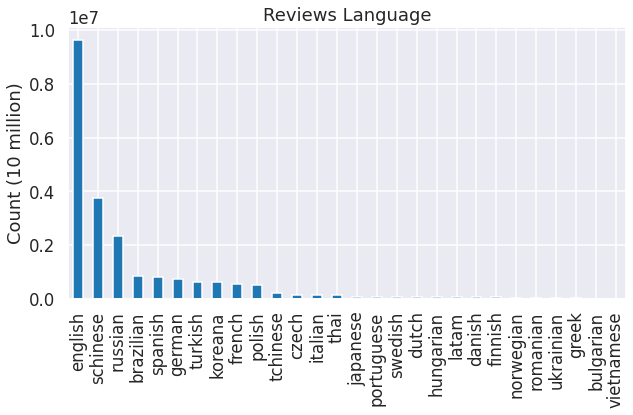

In [56]:
# Plot this information with a barplot
bar = language.plot.bar(figsize=(10,5))
bar.set_title('Reviews Language')
bar.set_ylabel('Count (10 million)')
plt.show()

#### *Create a function that receives as parameters both the name of a data set and a list of languages’ names and returns a data frame filtered only with the reviews written in the provided languages.*

In [57]:
def language_filter(data, languages):
    # The only parameters needed are the dataframe and a list of languages.
    data_filtered = data[data['language'].isin(languages)]
    # Consider only the values of the column 'language' that are in the list.
    return data_filtered

#### *Use the function created in the previous literal to find what percentage of these reviews (associated with the top 3 languages) were voted as funny?*

In [58]:
# We create a dataset with only the top 3 languages using the previous function
languages = ['english', 'schinese', 'russian']
data_filtered = language_filter(df4, languages)

In [59]:
# Find all the reviews with at least one vote as funny
funny = len(data_filtered[data_filtered['votes_funny'] > 0])
print('There are', funny, 'reviews with at least one vote as funny.')

# Find the percentage of these reviews.
funny_perc = (funny/len(data_filtered['language']))*100
print('It is the', round(funny_perc,2), '% of the reviews.')

There are 1922258 reviews with at least one vote as funny.
It is the 12.21 % of the reviews.


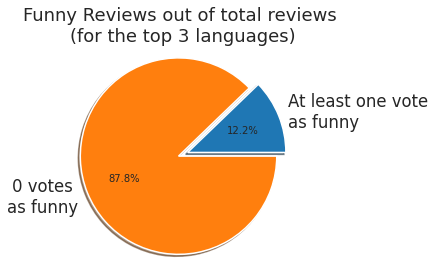

In [60]:
# Visualize it with a pie chart.
not_funny_perc = (100-funny_perc)
sizes = [funny_perc, not_funny_perc] # Assign the sizes of the pie
labels = 'At least one vote \nas funny', '0 votes \nas funny' # Labels of the pie
explode = (0.1, 0)  # only "explode" the 1st slice ('Funny')
fig1, ax1 = plt.subplots()
ax1.set_title('Funny Reviews out of total reviews \n(for the top 3 languages)')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [61]:
# What happen for each of the top 3 languages?
# Let's see with chinese.
chi = data_filtered[data_filtered['language'] == 'schinese']
c_funny= len(chi[chi['votes_funny'] > 0])
print('There are', c_funny, 'reviews in chinese with at least one vote as funny.')

# Find the percentage of these reviews.
c_funny_perc = (c_funny/len(chi['language']))*100
print('It is the', round(c_funny_perc,2), "% of the reviews in chinese.")

There are 444873 reviews in chinese with at least one vote as funny.
It is the 11.82 % of the reviews in chinese.


In [62]:
# Let's see with english.
eng = data_filtered[data_filtered['language'] == 'english']
e_funny= len(eng[eng['votes_funny'] > 0])
print('There are', e_funny, 'reviews in english with at least one vote as funny.')

# Find the percentage of these reviews.
e_funny_perc = (e_funny/len(chi['language']))*100
print('It is the', round(e_funny_perc,2), "% of the reviews in english.")

There are 1085690 reviews in english with at least one vote as funny.
It is the 28.84 % of the reviews in english.


In [63]:
# Let's see with russian.
rus = data_filtered[data_filtered['language'] == 'russian']
r_funny= len(rus[rus['votes_funny'] > 0])
print('There are', r_funny, 'reviews in russian with at least one vote as funny.')

# Find the percentage of these reviews.
r_funny_perc = (r_funny/len(rus['language']))*100
print('It is the', round(r_funny_perc,2), "% of the reviews in russian.")

There are 391695 reviews in russian with at least one vote as funny.
It is the 16.68 % of the reviews in russian.


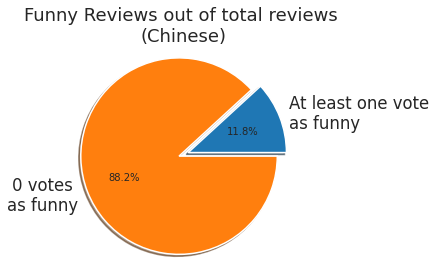

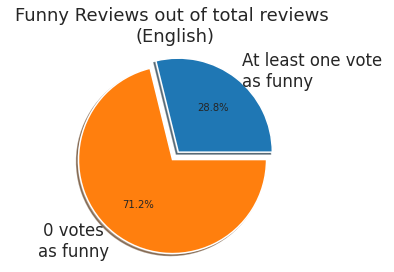

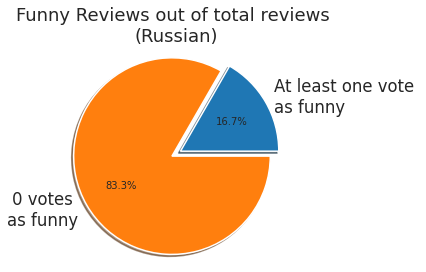

In [64]:
# Let's compare the three different pie charts.

# Chinese
c_not_funny_perc = (100-c_funny_perc)
sizes = [c_funny_perc, c_not_funny_perc] # Assign the sizes of the pie
labels = 'At least one vote \nas funny', '0 votes \nas funny' # Labels of the pie
explode = (0.1, 0)  # only "explode" the 1st slice ('Funny')

fig1, ax1 = plt.subplots()
ax1.set_title('Funny Reviews out of total reviews \n(Chinese)')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# English
e_not_funny_perc = (100-e_funny_perc)
sizes = [e_funny_perc, e_not_funny_perc] # Assign the sizes of the pie
labels = 'At least one vote \nas funny', '0 votes \nas funny' # Labels of the pie
explode = (0.1, 0)  # only "explode" the 1st slice ('Funny')

fig1, ax1 = plt.subplots()
ax1.set_title('Funny Reviews out of total reviews \n(English)')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Russian
r_not_funny_perc = (100-r_funny_perc)
sizes = [r_funny_perc, r_not_funny_perc] # Assign the sizes of the pie
labels = 'At least one vote \nas funny', '0 votes \nas funny' # Labels of the pie
explode = (0.1, 0)  # only "explode" the 1st slice ('Funny')

fig1, ax1 = plt.subplots()
ax1.set_title('Funny Reviews out of total reviews \n(Russian)')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The english reviews have an higher percentage of funny votes ($28.8\%$) than russian reviews ($16.7\%$) and chinese reviews ($11.8\%$). 

#### *Use the function created in the literal “a” to find what percentage of these reviews (associated with the top 3 languages) were voted as helpful?*

In [65]:
# Find all the reviews with at least one vote as helpful
help = len(data_filtered[data_filtered['votes_helpful'] > 0])
print('There are', help, 'reviews with at least one vote as helpful.')

# Find the percentage of these reviews.
help_perc = (help/len(data_filtered['language']))*100
print('It is the', round(help_perc,2), '% of the reviews.')

There are 4592926 reviews with at least one vote as helpful.
It is the 29.16 % of the reviews.


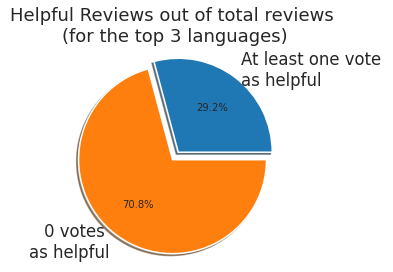

In [66]:
# Visualize it with a pie chart.
not_help_perc = (100-help_perc)
sizes = [help_perc, not_help_perc] # Assign the sizes of the pie
labels = 'At least one vote \nas helpful', '0 votes \nas helpful' # Labels of the pie
explode = (0.1, 0)  # only "explode" the 1st slice ('Funny')
fig1, ax1 = plt.subplots()
ax1.set_title('Helpful Reviews out of total reviews \n(for the top 3 languages)')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [67]:
# What happen for each of the top 3 languages?
# Let's see with chinese.
chi = data_filtered[data_filtered['language'] == 'schinese']
c_help= len(chi[chi['votes_helpful'] > 0])
print('There are', c_help, 'reviews in chinese with at least one vote as helpful.')

# Find the percentage of these reviews.
c_help_perc = (c_help/len(chi['language']))*100
print('It is the', round(c_help_perc,2), "% of the reviews in chinese.")

There are 945157 reviews in chinese with at least one vote as helpful.
It is the 25.1 % of the reviews in chinese.


In [68]:
# Let's see with english.
eng = data_filtered[data_filtered['language'] == 'english']
e_help= len(eng[eng['votes_helpful'] > 0])
print('There are', e_help, 'reviews in english with at least one vote as helpful.')

# Find the percentage of these reviews.
e_help_perc = (e_help/len(eng['language']))*100
print('It is the', round(e_help_perc,2), "% of the reviews in english.")

There are 2813873 reviews in english with at least one vote as helpful.
It is the 29.2 % of the reviews in english.


In [69]:
# Let's see with russian.
rus = data_filtered[data_filtered['language'] == 'russian']
r_help= len(rus[rus['votes_helpful'] > 0])
print('There are', r_help, 'reviews in russian with at least one vote as helpful.')

# Find the percentage of these reviews.
r_help_perc = (r_help/len(rus['language']))*100
print('It is the', round(r_help_perc,2), "% of the reviews in russian.")

There are 833896 reviews in russian with at least one vote as helpful.
It is the 35.5 % of the reviews in russian.


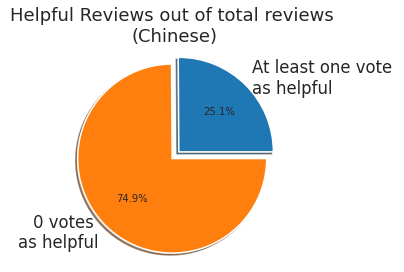

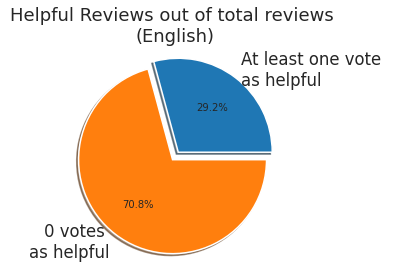

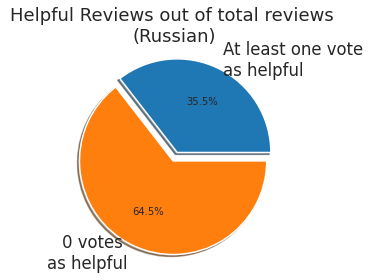

In [70]:
# Let's compare the three different pie charts.

# Chinese
c_not_help_perc = (100-c_help_perc)
sizes = [c_help_perc, c_not_help_perc] # Assign the sizes of the pie
labels = 'At least one vote \nas helpful', '0 votes \nas helpful' # Labels of the pie
explode = (0.1, 0)  # only "explode" the 1st slice ('Helpful')

fig1, ax1 = plt.subplots()
ax1.set_title('Helpful Reviews out of total reviews \n(Chinese)')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# English
e_not_help_perc = (100-e_help_perc)
sizes = [e_help_perc, e_not_help_perc] # Assign the sizes of the pie
labels = 'At least one vote \nas helpful', '0 votes \nas helpful' # Labels of the pie
explode = (0.1, 0)  # only "explode" the 1st slice ('Helpful')

fig1, ax1 = plt.subplots()
ax1.set_title('Helpful Reviews out of total reviews \n(English)')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Russian
r_not_help_perc = (100-r_help_perc)
sizes = [r_help_perc, r_not_help_perc] # Assign the sizes of the pie
labels = 'At least one vote \nas helpful', '0 votes \nas helpful' # Labels of the pie
explode = (0.1, 0)  # only "explode" the 1st slice ('Helpful')

fig1, ax1 = plt.subplots()
ax1.set_title('Helpful Reviews out of total reviews \n(Russian)')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The russian reviews have an higher percentage of helpful reviews ($35.5\%$) than english reviews ($29.2\%$) and chinese reviews ($25.1\%$).

## **[RQ5]**

#### *The reviews' authors are users from the game that provide their opinion on it. Now you can check how often they make reviews.*

In [71]:
def filtered_chunk(data):
    
    # We set the column type in order to reduce their dimension
    types_diz = {'author.num_reviews':'int32', 'votes_funny':'int32', 'votes_helpful':'int32', 'comment_count':'int32'}
    
    # Subset the columns we need from our dataset
    columns = ['author.steamid', 'author.num_reviews', 'app_name', 'votes_funny', 'votes_helpful', 'comment_count',
               'steam_purchase', 'received_for_free', 'recommended']

    # We decided to delete all the rows with at least one NA value, instead of assign a default value
    # We subset the column, drop the NA and finally convert the types
    db = data[columns].dropna(subset=columns).astype(types_diz)
    return db

In [72]:
df5 = chunking()

#### *Plot the top 10 most popular reviewers and the number of reviews.*

In [73]:
# Extract the information about the reviewers and the number of reviews.
# We consider the most popular reviewers as the reviewers with the highest number of interactions.
# We consider as interactions votes_funny + votes_helpful + comment_count

# Groupby the different authors
reviewers = df5[['author.steamid', 'votes_funny', 'votes_helpful', 'comment_count']].groupby(['author.steamid']).sum()

# Sum each rows to get the number of interactions, sort in descending order and pick only the top 10
interactions = reviewers.sum(axis=1).sort_values(ascending=False).head(10)

In [74]:
print(interactions)

author.steamid
76561198035100704    43134
76561198354182544    33586
76561198290310711    30297
76561198301163938    30206
76561198027414971    29263
76561198301678331    28525
76561198059761824    24551
76561198434676684    24349
76561198148948422    23506
76561198284938904    23239
dtype: int64


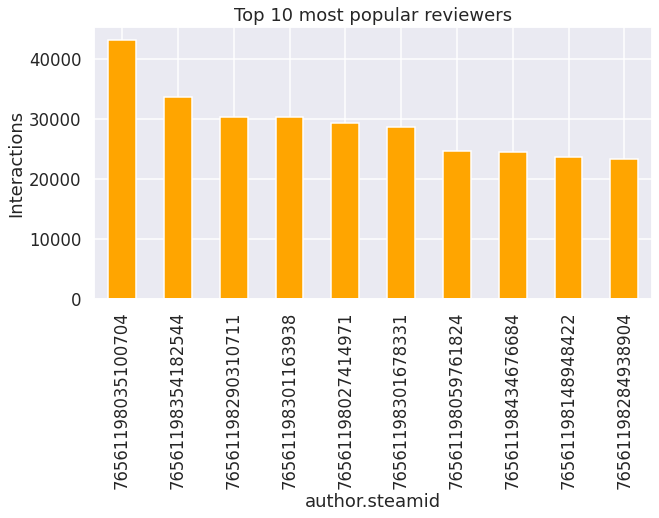

In [75]:
# Plot
bar = interactions.plot.bar(color = 'orange', figsize=(10,5))
bar.set_title('Top 10 most popular reviewers')
bar.set_ylabel('Interactions')
plt.show()

In [76]:
popular_reviewers = ['76561198035100704', '76561198354182544', '76561198290310711', '76561198301163938', '76561198027414971',
                     '76561198301678331', '76561198059761824', '76561198434676684', '76561198148948422', '76561198284938904']

# Select the top 10 most popular reviewer, count their number of reviews and sort in descending order
num_reviews = df5[df5['author.steamid'].isin(popular_reviewers)].groupby(['author.steamid']).count()['app_name'].sort_values(ascending=False)
print(num_reviews)

author.steamid
76561198354182544    12
76561198148948422    11
76561198284938904     9
76561198035100704     8
76561198301163938     5
76561198301678331     3
76561198434676684     2
76561198290310711     2
76561198059761824     1
76561198027414971     1
Name: app_name, dtype: int64


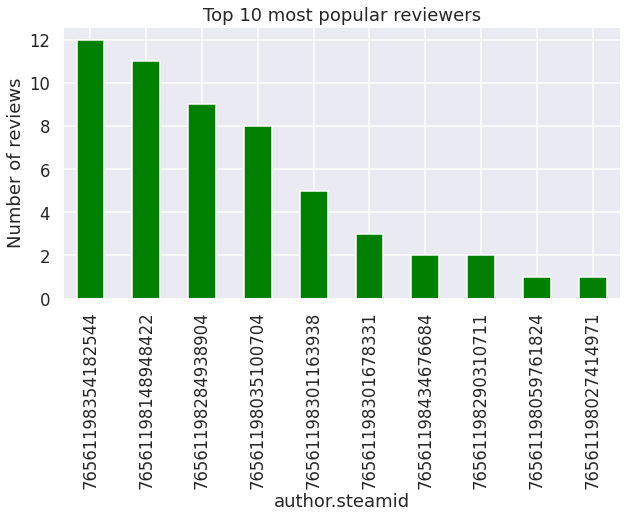

In [77]:
# Plot
bar = num_reviews.plot.bar(color = 'green', figsize=(10,5))
bar.set_title('Top 10 most popular reviewers')
bar.set_ylabel('Number of reviews')
plt.show()

We can observe that the most popular author is not the author with the higher number of reviews and there are some very popular authors who did only one review.

The most popular reviewer is the author *76561198035100704*.

#### *What applications did the most popular author review?*

In [78]:
# Create a dataset only for the most popular author (selected by row) and the 'app_name' column.
mp_author_id = 76561198035100704
mp_author = df5[df5['author.steamid'] == mp_author_id]
print('The most popular author reviewed', len(mp_author), 'apps:\n', mp_author['app_name'])

The most popular author reviewed 8 apps:
 142601           The Witcher 3: Wild Hunt
3594537                Salt and Sanctuary
5090095        Sekiro™: Shadows Die Twice
9570459                         Undertale
12189063                BioShock Infinite
15079531    PLAYERUNKNOWN'S BATTLEGROUNDS
17504379                  DARK SOULS™ III
17812071                     Watch_Dogs 2
Name: app_name, dtype: object


#### *How many applications did he purchase, and how many did he get as free? Provide the number (count) and the percentage.*

In [79]:
# Count the app he purchased
purchase = mp_author[mp_author['steam_purchase'] == True]['steam_purchase'].count()
print('He purchased', purchase, 'applications.')
print('The', round(purchase*100/len(mp_author), 1), '% of the app he reviewed.')

He purchased 8 applications.
The 100.0 % of the app he reviewed.


In [80]:
# Count the app he get as free
free = mp_author[mp_author['received_for_free'] == True]['received_for_free'].count()
print('He received for free', free, 'applications.')
print('The', round(free*100/len(mp_author), 1), '% of the app he reviewed.')

He received for free 0 applications.
The 0.0 % of the app he reviewed.


The most popular author purchased all the applications he reviewed.

#### *How many of the applications he purchased reviewed positively, and how many negatively? How about the applications he received for free?*

In [81]:
# Count how many of the applications he purchased he recommended (reviewed positively)
p = mp_author[mp_author['steam_purchase'] == True]
rec = p[p['recommended'] == True]['recommended'].count()
print('He recommends', rec, 'applications he purchased. The', round(rec*100/len(mp_author), 1), '%.')

print('The applications he recommends are:', list(p[p['recommended'] == True]['app_name']))

He recommends 6 applications he purchased. The 75.0 %.
The applications he recommends are: ['The Witcher 3: Wild Hunt', 'Sekiro™: Shadows Die Twice', 'Undertale', 'BioShock Infinite', 'DARK SOULS™ III', 'Watch_Dogs 2']


In [82]:
# Count how many of the applications he purchased he does not recommend (reviewed negatively)
not_rec = p[p['recommended'] == False]['recommended'].count()
print('He does not recommend', not_rec, 'applications he purchased. The', round(not_rec*100/len(mp_author), 1), '%.')

print('The applications he does not recommend are:', list(p[p['recommended'] == False]['app_name']))

He does not recommend 2 applications he purchased. The 25.0 %.
The applications he does not recommend are: ['Salt and Sanctuary', "PLAYERUNKNOWN'S BATTLEGROUNDS"]


He didn't receive any app for free, so he couldn't review one.

## **[RQ6]**

#### *It's time to get information from the updates that a user does to his reviews.*

In [83]:
def filtered_chunk(data):
    
    # We set the column type in order to reduce their dimension
    types_diz = {}
    
    # Subset the columns we need from our dataset
    columns = ['author.steamid', 'timestamp_created', 'timestamp_updated']
    
    # We decided to delete all the rows with at least one NA value, instead of assign a default value
    # We subset the column, drop the NA and finally convert the types
    db = data[columns].dropna(subset=columns).astype(types_diz)
    return db

In [84]:
df6 = chunking()

#### *What is the average time (days and minutes) a user lets pass before he updates a review?*

In [85]:
# Compute the difference between the timestamp_created and the timestamp_updated columns, to get the time passed from
# the creation of the review until its update.
# Then, because our time columns are in a timedelta64[np] format, we need to transform it into seconds.
sec = df6[['timestamp_created', 'timestamp_updated']].diff(axis=1)['timestamp_updated'].astype('timedelta64[s]')

# Then, we can obtain minutes dividing by 60
min = sec/60

# Calculating the average minutes necessary to update a review
av_min = sum(min)/len(min)

# We can transform this number into days
av_days = av_min/(60*24)

# To express the average time in days and minutes, we transform the decimals of this number into minutes
dec_to_min = (av_days - int(av_days))*24*60

print('The average time a user lets pass before he updates a review is of', int(av_days), 'days and', round(dec_to_min,2), 'minutes.')

The average time a user lets pass before he updates a review is of 36 days and 213.17 minutes.


#### *Plot the top 3 authors that usually update their reviews.*

In [86]:
# Count how many times an author update his reviews, by checking how many times timestamp_created != timestamp_updated
# Then group the results by author, count how many times the condition is verified, sort in descending order and pick the top 3.
updaters = df6[df6['timestamp_created'] != df6['timestamp_updated']].groupby('author.steamid')['timestamp_updated'].count().sort_values(ascending=False).head(3)
print(updaters)

author.steamid
76561198192166873    95
76561198206999976    61
76561198072450805    60
Name: timestamp_updated, dtype: int64


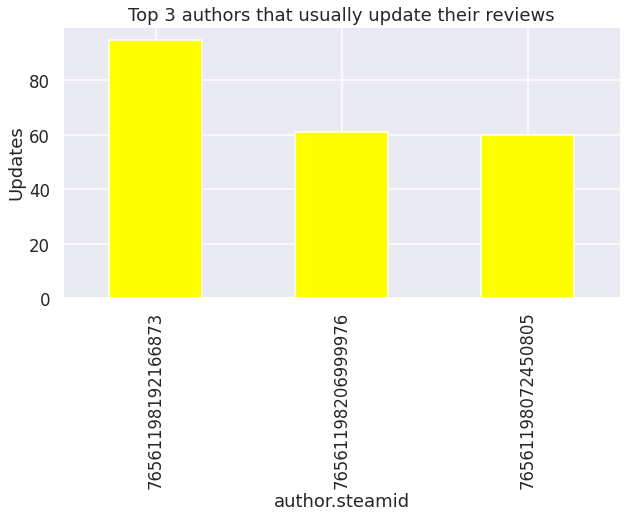

In [87]:
# Plot them with a bar chart.
bar = updaters.plot.bar(color = 'yellow', figsize=(10,5))
bar.set_title('Top 3 authors that usually update their reviews')
bar.set_ylabel('Updates')
plt.show()

## **[RQ7]**

#### *Of course, calculating probabilities is a job that any Data Scientist must know. Let's compute Some interesting figures.*

In [88]:
def filtered_chunk(data):
    
    # We set the column type in order to reduce their dimension
    types_diz = {'weighted_vote_score':'float32', 'votes_funny':'int32'}
    
    # Subset the columns we need from our dataset 
    columns = ['weighted_vote_score', 'votes_funny']
  
    # We decided to delete all the rows with at least one NA value, instead of assign a default value
    # We subset the column, drop the NA and finally convert the types
    db = data[columns].dropna(subset=columns).astype(types_diz)
    return db

In [89]:
df7 = chunking()

#### *What’s the probability that a review has a Weighted Vote Score equal to or bigger than 0.5?*

In [90]:
# Array of the weighted vote scores equal or bigger than 0.5
best_wvs = df7[df7['weighted_vote_score'] >= 0.5] 

# The probability that a review has a WVS >= 0.5 corresponds to the number of reviews with a weighted vote score 
# equal to or bigger than 0.5 divided by the total number of the reviews.
prob_1 = len(best_wvs)/len(df7['weighted_vote_score'])

print('The probability that a review has a Weighted Vote Score equal to or bigger than 0.5 is:', round(prob_1, 3))

The probability that a review has a Weighted Vote Score equal to or bigger than 0.5 is: 0.22


#### *What’s the probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5?*

We can use the Conditional Probability's formula:
$$P(A|B)=\frac{P(A \cap B)}{P(B)}$$

In our case: 
* the *event $A$* corresponds to: reviews with at least one vote as funny
* the *event $B$* corresponds to: reviews with weighted vote score bigger than 0.5

In [91]:
# Get the array for the reviews with weighted vote score bigger than 0.5 (B)
B = df7[df7['weighted_vote_score'] > 0.5]
# Get the array for A∩B (review with at least one vote as funny)
A_int_B = B[B['votes_funny'] > 0]

# Using the formula, we divide the number of reviews with at least one vote as funny and wvs bigger than 0.5 
# for the number of reviews with wvs bigger than 0.5.
prob2 = len(A_int_B)/len(B)
print('The probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5 is:', round(prob2, 3))

The probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5 is: 0.25


#### *Is the probability that “a review has at least one vote as funny” independent of the “probability that a review has a Weighted Vote Score equal or bigger than 0.5”?*

To check independence we use the definition that says:

Two events are independent if: $$P(A) * P(B) = P(A \cap B)$$

In our case: 
* the *event $A$* corresponds to: reviews with at least one vote as funny
* the *event $B$* corresponds to: reviews with weighted vote score equal to or bigger than 0.5

In [92]:
B = best_wvs # reviews with weighted vote score equal to or bigger than 0.5 computed previously
A = df7[df7['votes_funny'] > 0] # reviews with at least one vote as funny

prob_b = prob_1 # probability computed previuosly
print('P(B) =', round(prob_b, 3))

# P(A) is equal to the number of reviews with at least one vote as funny divided to the total number of reviews
prob_a = len(A)/len(df7['votes_funny'])
print('P(A) =', round(prob_a, 3))

# Get the intersection between the two events
A_int_B = A[A['weighted_vote_score'] >= 0.5]
# Get the probability dividing it to the total number of reviews
prob_a_int_b = len(A_int_B)/len(df7)
print('P(A∩B) =', round(prob_a_int_b, 3))

# Compute the product between P(A) and P(B)
prod = prob_a * prob_b
print('P(A)*P(B) =', round(prod, 3))

#Are they independent?
print('The two events are independent?', prod == prob_a_int_b)

P(B) = 0.22
P(A) = 0.12
P(A∩B) = 0.055
P(A)*P(B) = 0.026
The two events are independent? False


The probability that a review has at least one vote as funny is ***not*** independent of the probability that a review has a weighted vote score equal to or bigger than 0.5.

It means that a review with an higher weighted vote score has a better probability to get at least one vote as funny or viceversa.

## **[RQ8]**

#### *Every decision you take in a data-based environment should be reinforced with charts, statistical tests and analysis methods to check if a hypothesis is correct or not.*

In [93]:
def filtered_chunk(data):
    
    # We set the column type in order to reduce their dimension
    types_diz = {'language':'str', 'votes_helpful':'int32', 'votes_funny':'int32', 'weighted_vote_score':'float32'}
    
    # Subset the columns we need from our dataset 
    columns = ['language', 'votes_helpful', 'votes_funny', 'weighted_vote_score', 'timestamp_created', 
               'timestamp_updated', 'recommended']
   
    # We decided to delete all the rows with at least one NA value, instead of assign a default value
    # We subset the column, drop the NA and finally convert the types
    db = data[columns].dropna(subset=columns).astype(types_diz)
    return db

In [95]:
df8 = chunking()

#### *Is there a significant difference in the Weighted Vote Score of reviews made in Chinese vs the ones made in Russian? Use an appropriate statistical test or technique and support your choice.*

In [96]:
# Selecting the Weighted Vote Score of the reviews made in chinese.
chi = df8[df8['language'] == 'schinese']['weighted_vote_score']

In [97]:
# Visualizing a summary of the variable.
chi.describe()

count   3,764,967.00
mean            0.15
std             0.24
min             0.00
25%             0.00
50%             0.00
75%             0.48
max             1.00
Name: weighted_vote_score, dtype: float64

We have $3,764,967$ reviews made in chinese. 

The average Weighted Vote Score of these reviews is $0.15$.

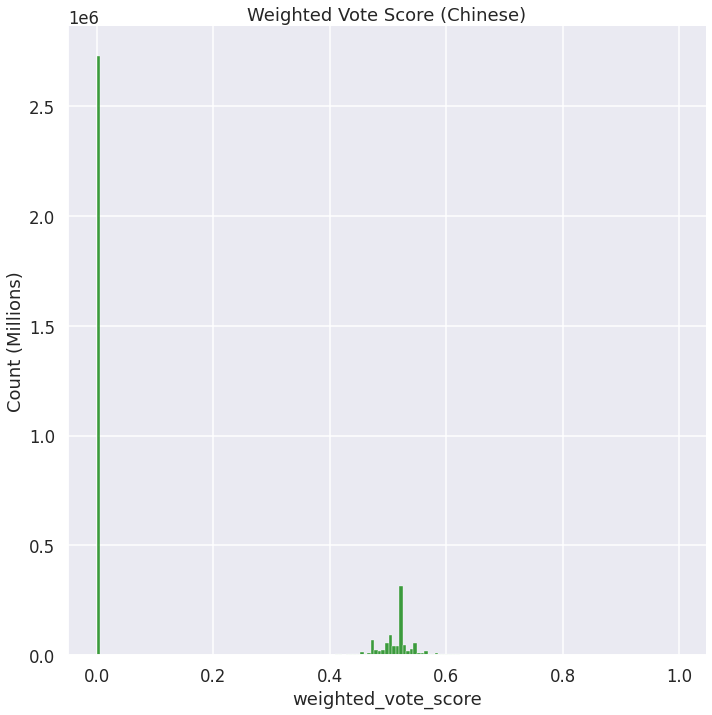

In [98]:
# Visualizing the histogram of the scores.
c = sns.displot(chi, color='green', height=10, aspect=1)
c.set(title = 'Weighted Vote Score (Chinese)', ylabel = 'Count (Millions)')

In [99]:
# Selecting the Weighted Vote Score of the reviews made in russian.
rus = df8[df8['language'] == 'russian']['weighted_vote_score']

In [100]:
# Visualizing a summary of the variable.
rus.describe()

count   2,348,900.00
mean            0.21
std             0.26
min             0.00
25%             0.00
50%             0.00
75%             0.51
max             0.99
Name: weighted_vote_score, dtype: float64

We have $2,348,900$ reviews made in Russian.

The average Weighted Vote Score of these reviews is $0.21$.

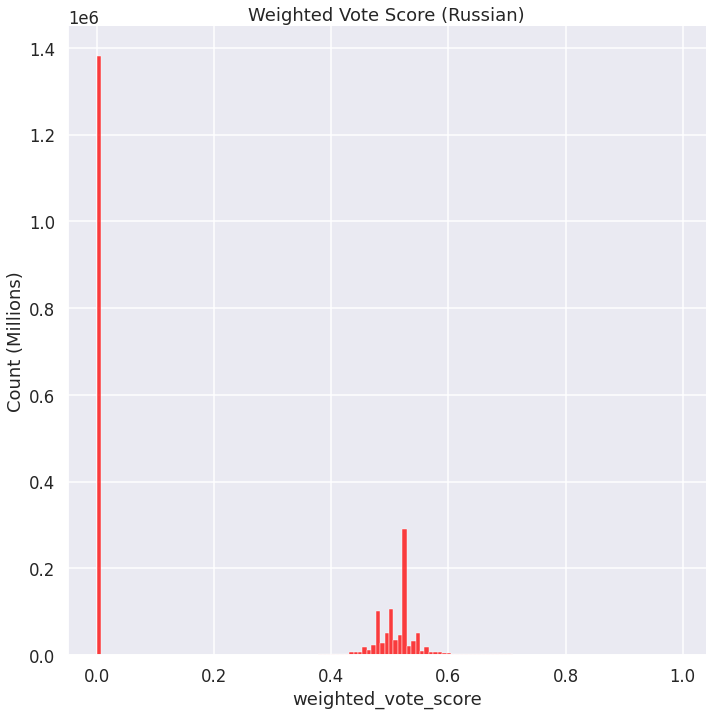

In [101]:
# Visualizing the histogram of the scores
r = sns.displot(rus, color='red', height=10, aspect=1)
r.set(title = 'Weighted Vote Score (Russian)', ylabel = 'Count (Millions)')

Looking at the bar plots, they have something in common. Most of the reviews has a weighted vote score equal to 0, and then the two distributions look similars.

We can check if there is significant difference between them with some statistical tests.

In [102]:
# To test if the mean in the two independent variables is the same, using the T Test,
# first, we need to know if they have the same variance.
print('Chinese scores variance:', np.var(chi))
print('Russian scores variance:', np.var(rus))

# Levene test
s, p = levene(chi, rus)
print('Statistic:', s, 'P-value:', p)

Chinese scores variance: 0.05637282133102417
Russian scores variance: 0.06678738445043564
Statistic: 109836.46050118413 P-value: 0.0


The p-value=0 suggest that the two variables does not have the same variance.

In [103]:
# So, we need to use the Welch test to check if the variables have the same mean.
# We specify 'equal_var=False'. We can use this type of test because we have a very large population.
s, p = ttest_ind(chi, rus, equal_var=False)
print('Statistic:', s, 'P-value:', p)

Statistic: -325.8387978898905 P-value: 0.0


Also in this case we have a pvalue=0, so we refuse the hypotesis that the Chinese and Russian weighted vote scores are the same. We can say that there is a significant difference between them.

FInally, we can say that the russian reviews have an higher weighted vote score than the chinese ones.

#### *Can you find any significant relationship between the time that a user lets pass before he updates the review and the Weighted Vote Score? Use an appropriate statistical test or technique and support your choice.*

In [104]:
# Get the time that a user lets pass before he updates a review
sec = df8[['timestamp_created', 'timestamp_updated']].diff(axis=1)['timestamp_updated'].astype('timedelta64[s]')

[Text(0, 0.5, 'Weighted Vote Score'),
 Text(0.5, 0, 'Seconds passed to update a review (100 million)')]

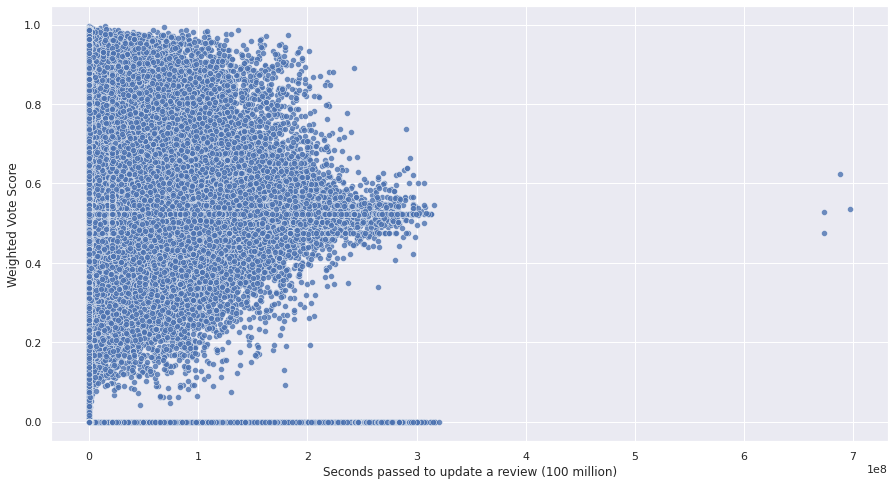

In [105]:
# Let's see graphically with a scatterplot if there is some kind of relationship between the two variables.
sns.set(rc = {'figure.figsize':(15,8)})
fig = sns.scatterplot(x=sec, y=df8['weighted_vote_score'], alpha=0.8)
fig.set(xlabel='Seconds passed to update a review (100 million)', ylabel='Weighted Vote Score')

Looking at the scatterplot, we can't see a particular pattern between data.

We can check it using a statistical correlation test.

In [106]:
# To check if there is a relation between the two variables we can use the Spearman correlation test
# because we can't assume the normality of the two distributions.
spearmanr(sec, df8['weighted_vote_score'])

SpearmanrResult(correlation=0.1442501958037846, pvalue=0.0)

The result from the Spearman test tells us that the two variables are incorrelated. (pvalue=0)

#### *Is there any change in the relationship of the variables mentioned in the previous literal if you include whether an application is recommended or not in the review? Use an appropriate statistical test or technique and support your choice.*

Let's see what happens if an applications is recommended in the review.

In [107]:
# Create a dataset for all the reviews that recommend the apps
recommended = df8[df8['recommended'] == True]

In [108]:
# Get the time that a user lets pass before he updates a review that recommends the app
sec_recommended = recommended[['timestamp_created', 'timestamp_updated']].diff(axis=1)['timestamp_updated'].astype('timedelta64[s]')

[Text(0, 0.5, 'Weighted Vote Score'),
 Text(0.5, 0, 'Seconds passed to update a review (100 million)'),
 Text(0.5, 1.0, 'Recommended')]

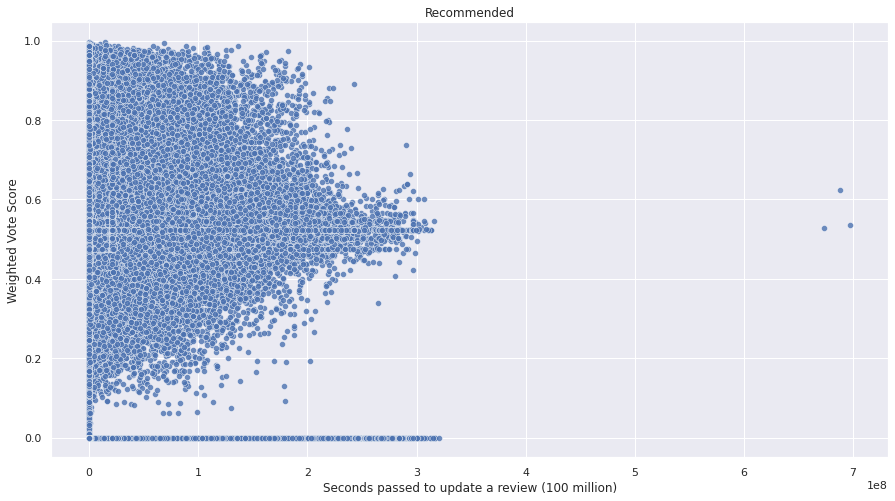

In [109]:
# Let's see graphically with a scatterplot if there is some kind of relationship between the two variables.
sns.set(rc = {'figure.figsize':(15,8)})
fig = sns.scatterplot(x=sec_recommended, y=recommended['weighted_vote_score'],    # Now we consider the weighted vote score of the
                      alpha=0.8, palette='viridis')                               # recommended apps.
fig.set(xlabel='Seconds passed to update a review (100 million)', ylabel='Weighted Vote Score', title='Recommended')

We see a plot that is very similar to the previous, so we can't get any particulat pattern between the variables.

We can check that with the Spearman correlation test.

In [110]:
spearmanr(sec_recommended, recommended['weighted_vote_score'])

SpearmanrResult(correlation=0.1458869156651231, pvalue=0.0)

We got a very similar correlation value and, again, a pvalue=0. So, the two variables are not correlated, even when the review recommend the app.

Let's see what happens when an application is not recommended.

In [111]:
# Create a dataset for all the reviews that not recommend the apps
not_recommended = df8[df8['recommended'] == False]

In [112]:
# Get the time that a user lets pass before he updates a review that doesn't recommend the app
sec_not_recommended = not_recommended[['timestamp_created', 'timestamp_updated']].diff(axis=1)['timestamp_updated'].astype('timedelta64[s]')

[Text(0, 0.5, 'Weighted Vote Score'),
 Text(0.5, 0, 'Seconds passed to update a review (100 million)'),
 Text(0.5, 1.0, 'Unrecommended')]

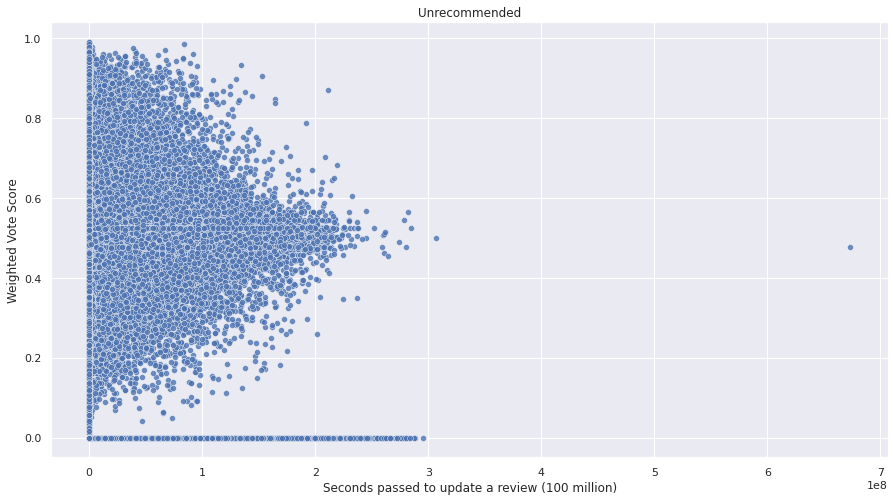

In [113]:
# Let's see graphically with a scatterplot if there is some kind of relationship between the two variables.
sns.set(rc = {'figure.figsize':(15,8)})
fig = sns.scatterplot(x=sec_not_recommended, y=not_recommended['weighted_vote_score'],  # Now we consider the weighted vote score
                      alpha=0.8, palette='flare')                                       # of the unrecommended apps.
fig.set(xlabel='Seconds passed to update a review (100 million)', ylabel='Weighted Vote Score', title='Unrecommended')

The plot remains always the same, even considering the reviews that doesn't recommend the apps.

Look at the Spearman correlation test.

In [114]:
spearmanr(sec_not_recommended, not_recommended['weighted_vote_score'])

SpearmanrResult(correlation=0.07239747512010913, pvalue=0.0)

As expected, we haven't correlation between the two variables. In addition, in this case the estimated correlation value is 0.07, less than the previous others.

We can say that there isn't any change in the relationship between the time that a user lets pass before he updates a review and the weighted vote score, given that the review recommends the app or not.

The two variables are always incorrelated. The only thing we can remark is that the marginal distribution of the weighted vote scores different from zero, seems to be bell-shaped.

#### *What are histograms, bar plots, scatterplots and pie charts used for?*

Histograms, bar plots, scatterplots and pie charts are the most popular and used tools for data visualization.

* **Histograms** are used for representing continuous variables divided into a series of intervals. These intervals must be adjacent and they can be also of different sizes. For each bin (interval) we have a rectangle. If the bins have the same size, the height of the rectangle is proportional to the frequency (the number of cases in each interval), otherwise the *area* of the rectangle has to be proportional to the frequency. In this last case, the height represent the *frequency density* (the number of cases per unit of the variable on the x-axis).

* **Bar plots** are used for comparing categorical data. For each category we have a rectangular bar which heigth is proportional to the value that represents. The bars can be horizontal or vertical.

* **Scatterplots** are plots used for representing values for (usually) two variables in a Cartesian diagram. Every value is represented by a point with coordinates equal to the value for the first variable on the x-axis and the value for the second variable on the y-axis. With a scatterplot we can detect relations and correlations between variables. They can be used for both continuous and discrete variables.

* **Pie charts** are circular statistical graphics. The 'pie' is divided into slices proportional to the quantity it represents. They are suited to express percentage and to observe the composition of a phenomena. The total of the percentages must be equal to 100%. If there are a lot of modalities related to the phenomena we want to represent, it can be worth to use a bar plot, because comparing the area of a lot of 'slices' can be difficult and not so easy.

#### *What insights can you extract from a Box Plot?*

With a **Box Plot** we analyze the distribution of a variable paying attention to its quartiles. In a box plot we can identify the first quartile (as the lower box edge), the median (as the line inside the box) and the third quartile (as the upper box edge). In the box plots can be plotted also lines representing the values located outside lower and upper quartiles. Outlier values can be represented by single points. 

In addition, we are able to know the variability and the dispersion of the variable, looking at the length of the box. If we have a little box, all the data are located near the median, so we have low dispersion; otherwise we have a larger box. We can also get information about the symmetry of a variable, if the median line is in the center of the box, maybe the variable is symmetric (but we always need to check it with statistical parameters); otherwise the line will be closer to one box edge (quartile) than the other.

# ***Theoretical Questions***

## **[TQ1]**

#### *Given the following algorithm.*

```
Input: 
    A: array of length n
    k: integers between 1 and n
    
function alg(A, k):
  s <-- a random element of A
  set L = [all the elements of A with value <= s]
  set R = [all the elements of A with value > s]
  r = len(L)
  if k == r:
    return s
  else if k < r:  
    return alg(L, k)
  else:
    return alg(R, k - r)
```




#### *What does the algorithm compute?*

This algorithm computes a partition of two subsets. It returns the value **s**, that corresponds to the value which has *k* values in the array that are less or equal than *s* and *n-k* values that are bigger.

#### *What is asymptotically (i.e., we are asking for big-O complexity) the running time of the algorithm in the worst case, as a function of n?*

Since this algoritm takes randomly a value in each call, this value can be, in the worst case, always the bigger value and so each time the function will call itself on the left array that is the starting array itself. Therefore this will lead to an infinite loop.

#### *What is asymptotically the running time of the algorithm in the best case?*

In the best case, this will be compute in $\theta(n)$, because it will randomly pick at the first call the right value and so the algoritm will only need to compute the partition in $\theta(n)$.

## **[TQ2]**

#### *You are given the recursive function splitSwap, which accepts an array $a$, an index $i$, and a length $n$.*



```
function splitSwap(a, l, n):
  if n <= 1:
    return
  splitSwap(a, l, n/2)
  splitSwap(a, l+ n /2, n/2)
  swapList(a, l, n)

```



The subroutine swapList is described here:


```
function swapList(a, l, n):
  for i = 0 to n/2:
    tmp = a[l + i]
    a[l + i] = a[l + n/2 + i]
    a[l + n/2 + i] = tmp

```



#### *How much running time does it take to execute splitSwap(a, 0, n)? (We want a Big O analysis.)*

The algorithm has a computational time that is in $O(n\log(n))$. It divides the starting array by $2$ for $\log(n)$ times and swap the elements.

#### *What does this algorithm do? Is it optimal? Describe the mechanism of the algorithm in details, we do not want to know only its final result.*

The algorithm computes a swapping (symmetry) between the elements of the array. A symmetry of radius $n/2$.

It's a recursive function, so when we are coming back, we start with arrays of dimension $1$, we swap the values and we create arrays of dimension $2$.

These arrays will be swapped with others arrays of dimension $2$, it will create arrays of dimension $4$ and so on, until it returns an array of the original dimension (where we have a symmetry of radius $n/2$).

## **[TQ3]**

#### *In the knapsack problem we are given $n$ objects and each object $i$ has a weight $w_i$ and a value $v_i$. We are also given a weight budget $W$. The problem is to select a set of objects with total weight bounded by $W$ that maximized the sum of their values.* 
The following are three natural heuristics, for each of the heuristics, provide a counterexample, that is, an example of a problem instance in which the heuristic fails to provide the optimal solution.

$W = 50$

object $i = (v_i, w_i)$

##### *Order them in increasing order of weight and then visit them sequentially, adding them to the solution as long as the budget is not exceeded.*

$l = [ (3,1), (31,2), (12,29), (100,49) ]$

This algorithm will take the first three values and so a total sum of values equal to $46$, howewer what it should have picked is the value $(100,49)$.

##### *Order them in decreasing order of values, and then visit them sequentially, adding them to the solution if the budget is not exceeded.*

$l = [ (40,49), (30,30), (20,10) ]$

The algorithm takes only the first one but it should have taken the other two.

##### *Order them in decreasing relative value $(v_i / w_i)$, and then visit them sequentially, adding them to the solution if the budget is not exceeded.*

$l = [ (100,50), (30,2), (12,2), (6,3) ]$

$a: 100/50 = 2$

$b: 6/2 = 3$

$c: 12/2 = 6$

$d: 30/2 = 15$

$l_{ordered} = [ (15), (6), (3), (2) ]$

The algorithm picks $(30,2)$ then $(12,2)$ and then $(6,3)$, so total value is $48$, but it should have picked $(100,50)$.